# Сегментация клиентов банка #

In [1]:
#pip install yellowbrick --user

In [2]:
import numpy as np

import pandas as pd
pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.style import set_palette

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

## 1. Разведочный анализ данных ##

In [3]:
df = pd.read_csv('HW1_var_9.csv', delimiter=';')
df.head()

,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,9,1000009,Форма банка (без печати работодателя),Покупка автомобиля,0.0,0.37,женский,0,0,среднее-специальное,вспомогательный персонал,>250,0.0,324.0,46.0,Транспорт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,1000029,Поступление зарплаты на счет,Ремонт,1.0,0.49,женский,0,0,среднее-специальное,вспомогательный персонал,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,1000049,2НДФЛ,Ремонт,1.0,0.24,женский,0,0,высшее,специалист,>250,0.0,35.0,25.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1000069,Поступление зарплаты на счет,Другое,1.0,0.26,мужской,0,0,высшее,специалист,>250,1.0,26.0,37.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,1000089,Форма банка (без печати работодателя),Покупка автомобиля,1.0,0.43,мужской,0,0,Высшее/Второе высшее/Ученая степень,вспомогательный персонал,>250,0.0,56.0,31.0,Другое,Государственное предприятие,холост / не замужем,0.0,0.0,0.0,0.0,0.0,0.023333,1.0,0.0,0.0,0.0,0.5,5.0,5.0,293.0,10.0,1.0,3.0,27.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(10243, 44)

In [5]:
print('Количество уникальных клиентов:', len(pd.unique(df.ID)))

Количество уникальных клиентов: 10243


В датасете 10243 объекта и 44 признака. Разделим переменные на номинальные, числовые и категориальные, а также разберемся, что они означают.

**Номинальные переменные:**
<ul>
    <li>Номер варианта</li>
    <li>ID - уникальный номер каждого клиента; выше мы выяснили, что у каждого объекта номер действительно индивидуальный, а значит ошибок в записи данных нет</li>
</ul>
Обе номинальные переменные необходимо удалить, так как они не несут в себе никакой информации. Более того, их присутствие ухудшает качество ML-моделей.

In [6]:
df.drop(columns=['Номер варианта', 'ID'], axis=1, inplace=True)

<b>Числовые переменные:</b>
<ul>
    <li>DTI - отношение долга к доходу - выражается в процентах (десятичной дробью)</li>
    <li>FULL_AGE_CHILD_NUMBER - количество детей</li>
    <li>DEPENDANT_NUMBER - количество иждивенцев</li>
    <li>Period_at_work - количество отработанных дней</li>
    <li>age - возраст</li>
    <li>max90days, max60days, max30days, max21days, max14days - количество обращений в кредитные бюро за последние 90, 60, 30, 21 и 14 дней соответственно</li>
    <li>avg_num_delay - среднее количество задолженностей по платежам</li>
    <li>num_AccountActive180, num_AccountActive90, num_AccountActive60 - количество действующих аккаунтов в последние 180, 90 и 60 дней соответственно</li>
    <li>Active_to_All_prc - доля действующих аккаунтов среди всех существующих у клиента</li>
    <li>numAccountActiveAll, numAccountClosed - количество действующих и закрытых аккаунтов соответственно</li>
    <li>sum_of_paym_months - объем выплат за последний месяц (тыс. руб)</li>
    <li>all_credits - количество кредитов</li>
    <li>Active_not_cc - количество действующих аккаунтов без кредитных карт</li>
    <li>own_closed - количество погашенных кредитов</li>
    <li>max_MnthAfterLoan, min_MnthAfterLoan - количество месяцев, прошедших с выдачи первого и последнего кредита соответственно</li>
</ul>
<b>Категориальные переменные:</b>
<ul>
    <li>INCOME_BASE_TYPE - подтверждение источника дохода</li>
    <li>CREDIT_PURPOSE - цель кредита</li>
    <li>INSURANCE_FLAG - информация о том, страхует ли клиент кредит</li>
    <li>SEX - пол</li>
    <li>EDUCATION - образование</li>
    <li>EMPL_TYPE - карьерная ступень</li>
    <li>EMPL_SIZE - величина зарплаты</li>
    <li>BANKACCOUNT_FLAG - наличие онлайн-аккаунта</li>
    <li>EMPL_PROPERTY - отрасль</li>
    <li>EMPL_FORM - организационно-правовая форма бизнеса</li>
    <li>FAMILY_STATUS - семейное положение</li>
    <li>if_zalog - наличие залога</li>
    <li>dlq_exist - наличие задолженности в настоящее время</li>
    <li>thirty_in_a_year, sixty_in_a_year, ninety_in_a_year - информация о том, была ли за последний год просрочка более чем в 30, 60 и 90 дней соответственно</li>
    <li>thirty_vintage, sixty_vintage, ninety_vintage - информация о том, была ли за все время просрочка более чем в 30, 60 и 90 дней соответственно</li>
</ul>
Уникальные значения, которые может принимать каждая категориальная переменная, и их количество можно увидеть в таблице ниже.

In [7]:
# непрерывные
num_feat = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age',
            'max90days', 'max60days', 'max30days', 'max21days', 'max14days', 'avg_num_delay',
            'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60', 'Active_to_All_prc',
            'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc',
            'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']

# категориальные
cat_feat = list(set(df.columns) - set(num_feat))

In [8]:
len(set(num_feat + cat_feat)) == df.shape[1]

True

In [9]:
def describe_cat_feat(df, features):    
    unique_values = [list(pd.unique(df[f'{i}'])) for i in df[features].columns]
    lengths = list(map(len, unique_values))
    unique_values = [(', ').join(sorted(map(str, unique_values[i]))) for i in range(len(unique_values))]

    cat_description = pd.DataFrame(dict(zip(df[features].columns, unique_values)), index=[0]).T
    cat_description.columns = ['Уникальные значения']
    cat_description['Число уникальных значений'] = lengths

    return cat_description

describe_cat_feat(df, cat_feat)

,Уникальные значения,Число уникальных значений
dlq_exist,"0.0, 1.0, nan",3
thirty_vintage,"0.0, 1.0, nan",3
INSURANCE_FLAG,"0.0, 1.0, nan",3
sixty_vintage,"0.0, 1.0, nan",3
thirty_in_a_year,"0.0, 1.0, nan",3
SEX,"женский, мужской",2
EMPL_TYPE,"nan, вспомогательный персонал, другое, менеджер высшего звена, менеджер по продажам, менеджер среднего звена, рабочий, специалист, страховой агент, торговый представитель",10
EMPL_SIZE,"*n.a.*, < 50, >100, >250, >=100, >=150, >=200, >=50, nan",9
ninety_in_a_year,"0.0, 1.0, nan",3
FAMILY_STATUS,"nan, вдовец / вдова, гражданский брак, женат / замужем, повторный брак, разведен / разведена, холост / не замужем",7


Заметно, что в переменных EDUCATION и EMPL_SIZE есть значения n.a., т.е. пропуски. Заменим их на стандартные значения None.

In [10]:
def standartize_na(df, feature):
    df[f'{feature}'] = np.where(df[f'{feature}'] == '*n.a.*', None, df[f'{feature}'])
    return df

df = standartize_na(standartize_na(df, 'EDUCATION'), 'EMPL_SIZE')

In [11]:
describe_cat_feat(df, cat_feat)['Число уникальных значений'].sum() - len(cat_feat)

86

В будущем категориальные переменные будут преобразованы с помощью one-hot-encoding. На данном этапе количество признаков при такой трансформации увеличилось бы на 86 единиц, что существенно много. Это можно исправить удалением/слиянием незначительных категорий или практически нулевых признаков. Будем придерживаться такой стратегии при подготовке данных.

In [12]:
df.dtypes

INCOME_BASE_TYPE          object
CREDIT_PURPOSE            object
INSURANCE_FLAG           float64
DTI                      float64
SEX                       object
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                 object
EMPL_TYPE                 object
EMPL_SIZE                 object
BANKACCOUNT_FLAG         float64
Period_at_work           float64
age                      float64
EMPL_PROPERTY             object
EMPL_FORM                 object
FAMILY_STATUS             object
max90days                float64
max60days                float64
max30days                float64
max21days                float64
max14days                float64
avg_num_delay            float64
if_zalog                 float64
num_AccountActive180     float64
num_AccountActive90      float64
num_AccountActive60      float64
Active_to_All_prc        float64
numAccountActiveAll      float64
numAccountClosed         float64
sum_of_paym_months       float64
all_credit

Все переменные приведены к соответствующему типу данных: категориальные признаки с текстовыми значениями относятся к типу object, а непрерывные и бинарные (0/1) - к float или int. Данные не требуют дополнительных преобразований, с ними можно работать.

**Исследование пропусков и нулевых значений**

In [13]:
def get_na(df):
    nans = pd.DataFrame({'Количество пропусков' : df.isna().sum(),
                         '% пропусков' : df.isna().sum() / len(df) * 100})
    return nans

(get_na(df).style.background_gradient(subset=['Количество пропусков'], cmap='Reds')
 .format('{:.1f}%', subset='% пропусков'))

,Количество пропусков,% пропусков
INCOME_BASE_TYPE,78,0.8%
CREDIT_PURPOSE,0,0.0%
INSURANCE_FLAG,1,0.0%
DTI,125,1.2%
SEX,0,0.0%
FULL_AGE_CHILD_NUMBER,0,0.0%
DEPENDANT_NUMBER,0,0.0%
EDUCATION,26,0.3%
EMPL_TYPE,12,0.1%
EMPL_SIZE,124,1.2%


Более половины столбцов содержат очень много пропущенных значений (60+ %). Для удобства восприятия сгруппируем объекты по количеству пропусков в строке, чтобы оценить полноту данных по клиентам.

In [14]:
nans_structure = pd.DataFrame([(i / df.shape[1] * 100, len(df[df.isna().sum(axis=1)==i]) / len(df) * 100)
                               for i in range(df.isna().sum(axis=1).max()+1)
                               if len(df[df.isna().sum(axis=1)==i]) != 0],
                              columns=['% пропусков в строке',
                                       '% таких строк в датасете'])

(nans_structure.style.background_gradient(subset=['% таких строк в датасете'], cmap='Reds')
 .format('{:.1f}%'))

,% пропусков в строке,% таких строк в датасете
0,0.0%,35.6%
1,2.4%,0.2%
2,4.8%,0.0%
3,11.9%,0.1%
4,50.0%,2.7%
5,61.9%,0.5%
6,66.7%,36.9%
7,69.0%,0.1%
8,71.4%,0.4%
9,73.8%,0.7%


Чуть более трети строк не содержат пропусков, еще чуть более трети не заполнены на 66,7%. Немного менее трети строк имеют 76,2% пропущенных значений.

Посмотрим, какие столбцы не заполнены у тех клиентов, которые попали на строку 6 таблицы выше.

In [15]:
df[df.isna().sum(axis=1) ==
   np.round(nans_structure.loc[6]['% пропусков в строке'] / 100 * df.shape[1])].sample(10)

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
8033,Форма банка (без печати работодателя),Ремонт,0.0,0.42,женский,1,0,Высшее/Второе высшее/Ученая степень,специалист,>250,0.0,146.0,34.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545,Форма банка (без печати работодателя),Ремонт,0.0,0.11,мужской,0,0,высшее,менеджер высшего звена,< 50,0.0,104.0,52.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9228,Форма банка (без печати работодателя),Покупка недвижимости/ строительство,1.0,0.33,мужской,0,0,среднее,вспомогательный персонал,>250,0.0,6.0,53.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,Свободная форма с печатью работодателя,Покупка недвижимости/ строительство,1.0,0.38,женский,2,0,высшее,вспомогательный персонал,< 50,1.0,83.0,37.0,Туризм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8270,Свободная форма с печатью работодателя,Ремонт,0.0,0.57,женский,1,0,высшее,специалист,>250,0.0,67.0,27.0,Транспорт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2601,2НДФЛ,Покупка автомобиля,0.0,0.44,мужской,0,0,высшее,специалист,>250,1.0,49.0,28.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6021,2НДФЛ,Покупка автомобиля,1.0,0.48,мужской,0,0,высшее,рабочий,>250,0.0,12.0,48.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6639,2НДФЛ,Ремонт,1.0,0.59,мужской,0,0,высшее,рабочий,>250,1.0,25.0,55.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2НДФЛ,Отпуск,1.0,0.28,женский,0,0,среднее-специальное,специалист,>250,1.0,7.0,31.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1611,Поступление зарплаты на счет,Ремонт,1.0,0.44,женский,1,0,высшее,специалист,>250,1.0,107.0,33.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Это информация об организационно-правовой форме, семейном положении, обращениям в кредитные бюро, просрочках, залоге, активных и закрытых аккаунтах, суммах платежей и других важных характеристиках.

Теперь посмотрим, какие клиенты попали на 10 строчку - значительная доля объектов с критически большим количеством пропусков.

In [16]:
df[df.isna().sum(axis=1) ==
   np.round(nans_structure.loc[10]['% пропусков в строке'] / 100 * df.shape[1])].sample(10)

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
5535,2НДФЛ,Ремонт,1.0,0.27,женский,0,0,среднее-специальное,вспомогательный персонал,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9483,Поступление зарплаты на счет,Покупка недвижимости/ строительство,1.0,0.42,женский,0,0,высшее,вспомогательный персонал,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8239,Форма банка (без печати работодателя),Ремонт,1.0,0.30,мужской,1,0,среднее-специальное,вспомогательный персонал,>=150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,Форма банка (без печати работодателя),Покупка недвижимости/ строительство,0.0,0.50,женский,0,0,Высшее/Второе высшее/Ученая степень,менеджер среднего звена,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4518,Форма банка (без печати работодателя),Другое,1.0,0.49,мужской,0,0,высшее,торговый представитель,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,Форма банка (без печати работодателя),Ремонт,0.0,0.49,мужской,0,0,незаконченное высшее,менеджер высшего звена,>100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7386,2НДФЛ,Ремонт,1.0,0.16,женский,0,0,высшее,рабочий,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Поступление зарплаты на счет,Ремонт,0.0,0.47,женский,0,0,высшее,специалист,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7918,2НДФЛ,Покупка недвижимости/ строительство,1.0,0.59,мужской,0,0,высшее,рабочий,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4725,Поступление зарплаты на счет,Ремонт,0.0,0.33,женский,0,0,Высшее/Второе высшее/Ученая степень,специалист,>=100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


У таких клиентов помимо перечисленных выше признаков отсутствует информация о возрасте, количестве рабочего времени и наличии онлайн-аккаунта. Первые две характеристики крайне важны. Они являются непрерывными переменными, поэтому их довольно сложно заполнять: при, например, импутации средним очень многие объекты будут иметь одинаковые значения, это сильно испортит распределения.

Итак, строки с критически большим количеством пропусков (более 67%) необходимо удалить - это чуть менее трети выборки. Далее возникает вопрос: как быть с объектами, где пропущенных значений пусть и не намного, но меньше? Можно пойти по одному из двух путей:
<ol>
    <li>Удалить таких клиентов, чтобы анализировать только полные данные и видеть четкую картинку без искажений. Недостаток такого подхода - сильное сокращение исходной выборки (примерно в 3 раза), но при решении бизнес-задач на практике с этой неприятностью приходится сталкиваться часто.</li>
    <li>Оставить клиентов и принять их за "новичков": они только пришли в банк, у них нет аккаунтов, кредитов, задолженностей и т.д., поэтому все пустые поля можно заполнить нулями; при этом банк знает важную информацию о клиентах (пол, возраст, работа, доход, количество детей и пр.), на основе которой можно определить их в тот или иной сегмент, чтобы иметь представление о том, как повышать лояльность каждого клиента. У этого подхода недостаток существенный: данные будут очень разреженными, средние и медианные значения - близкими к нулю, а значит качественный анализ провести вряд ли получится.</li>
</ol>
Недостаток второго метода перевешивает недостаток первого, поэтому решено оставить только существующих клиентов с полными данными, т.е. удалить объекты с количеством пропусков больше нуля.

In [17]:
df = df[df.isna().sum(axis=1) <=
        np.round(nans_structure.loc[0]['% пропусков в строке'] / 100 * df.shape[1])]

df.shape

(3649, 42)

Как было отмечено ранее, от исходной выборки осталась примерно треть объектов.

In [18]:
df.isna().sum().sum()

0

Пропусков в данных не осталось. Теперь посмотрим на количество нулей, которое содержит каждый признак.

In [19]:
def get_zeros(df):
    zeros = pd.DataFrame({'Количество нулей' : [df==0][0].sum(),
                          '% нулей' : [df==0][0].sum() / len(df) * 100})
    return zeros

In [20]:
(get_zeros(df).style.background_gradient(subset=['Количество нулей'], cmap='Reds')
 .format('{:.1f}%', subset='% нулей'))

,Количество нулей,% нулей
INCOME_BASE_TYPE,0,0.0%
CREDIT_PURPOSE,0,0.0%
INSURANCE_FLAG,1386,38.0%
DTI,0,0.0%
SEX,0,0.0%
FULL_AGE_CHILD_NUMBER,2246,61.6%
DEPENDANT_NUMBER,3636,99.6%
EDUCATION,0,0.0%
EMPL_TYPE,0,0.0%
EMPL_SIZE,0,0.0%


Переменные DEPENDANT_NUMBER, num_AccountActive60, sixty_in_a_year, ninety_in_a_year, thirty_vintage, sixty_vintage, ninety_vintage очень разреженные, в них более 90% нулевых значений. Из-за сильного дисбаланса они становятся неинформативными и только увеличивают размерность данных, поэтому их нужно удалить.

In [21]:
lack_info = ['DEPENDANT_NUMBER', 'num_AccountActive60',
             'sixty_in_a_year', 'ninety_in_a_year',
             'thirty_vintage', 'sixty_vintage', 'ninety_vintage']

In [22]:
def remove_columns(df, names, num, cat, threshold):
    df.drop(columns=names, axis=1, inplace=True)

    num = list(set(num) - set(names[:threshold]))
    cat = list(set(cat) - set(names[threshold:]))

    status = 'OK' if len(num) + len(cat) == df.shape[1] else 'Not OK'
         
    return status, num, cat

In [23]:
cleared = remove_columns(df, lack_info, num_feat, cat_feat, 2)
num_feat, cat_feat = cleared[1], cleared[2]

**Исследование данных на ошибки**

In [24]:
print(*[(i, len(df[df[f'{i}'] < 0])) for i in num_feat
        if len(df[df[f'{i}'] < 0]) != 0], sep='\n')

('min_MnthAfterLoan', 11)


В переменной min_MnthAfterLoan 11 отрицательных значений - удалим такие объекты. В остальных числовых признаках все значения неотрицательные.

In [25]:
df = df[df.min_MnthAfterLoan >= 0]

In [26]:
len(df[df.max_MnthAfterLoan - df.min_MnthAfterLoan < 0])

0

Объектов, где количество месяцев после последнего займа больше, чем после первого, нет.

In [27]:
len(df[df.numAccountActiveAll - df.num_AccountActive180 < 0])

0

Нет таких клиентов, у которых количество активных аккаунтов за последние 180 дней больше, чем за все время.

In [28]:
l = np.array([14, 21, 30, 60, 90])
u = l
m = np.meshgrid(l, u)
cnt = 0

for i in range(len(l)):
    for j in range(len(u)):
        if (m[0] - m[1] > 0)[i,j] == True:
            error = len(df[df[f'max{m[0][i,j]}days'] - df[f'max{m[1][i,j]}days'] < 0])
            if error > 0:
                print(m[0][i,j], m[1][i,j], error)
            else:
                cnt += 1

if cnt == (m[0] - m[1] > 0).sum():
    print('Ошибок нет')

Ошибок нет


В количестве обращений за разные промежутки времени нет ошибок: за последние 14 дней их не больше, чем за последние 21, 30, 60 и 90, за последние 21 - не больше, чем за 30, 60 и 90, и т.д.

In [29]:
np.round((df.age - df.max_MnthAfterLoan / 12).min(), 2)

15.08

Минимальный возраст клиента на момент выдачи первого кредита - 15 лет. Это не противоречит законодательству РФ, так как с 14-летнего возраста можно брать, например, образовательный кредит. Посмотрим на клиентов, которые брали свой первый кредит в несовершеннолетнем возрасте:

In [30]:
df[df.age - df.max_MnthAfterLoan / 12 < 18]

,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year
192,Поступление зарплаты на счет,Покупка автомобиля,1.0,0.26,мужской,0,высшее,специалист,>250,0.0,22.0,26.0,Торговля,ООО,холост / не замужем,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,6.0,1.0,0.0,0.0,100.0,100.0,0.0,0.0
1820,Поступление зарплаты на счет,Ремонт,1.0,0.47,женский,0,высшее,специалист,>250,0.0,31.0,25.0,Другое,Иная форма,холост / не замужем,2.0,2.0,0.0,0.0,0.0,0.032258,0.0,1.0,1.0,0.333333,2.0,4.0,60.0,6.0,1.0,2.0,1.0,86.0,1.0,0.0
4683,Поступление зарплаты на счет,Ремонт,1.0,0.26,женский,1,высшее,менеджер среднего звена,>250,0.0,12.0,26.0,Торговля,ООО,женат / замужем,5.0,4.0,3.0,2.0,1.0,0.107143,1.0,3.0,3.0,0.400000,4.0,6.0,50.0,10.0,3.0,0.0,0.0,102.0,1.0,1.0
4685,Поступление зарплаты на счет,Отпуск,1.0,0.46,женский,0,высшее,вспомогательный персонал,< 50,0.0,10.0,23.0,Торговля,ОАО,холост / не замужем,1.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4.0,20.0,4.0,0.0,0.0,6.0,65.0,0.0,0.0
6185,Свободная форма с печатью работодателя,Покупка автомобиля,0.0,0.38,мужской,0,высшее,вспомогательный персонал,>250,0.0,19.0,25.0,Торговля,ООО,женат / замужем,0.0,0.0,0.0,0.0,0.0,0.355556,0.0,2.0,0.0,0.400000,2.0,3.0,29.0,5.0,1.0,0.0,5.0,86.0,1.0,1.0
6459,Форма банка (без печати работодателя),Другое,0.0,0.22,мужской,2,среднее-специальное,специалист,>250,0.0,83.0,30.0,Торговля,ЗАО,женат / замужем,0.0,0.0,0.0,0.0,0.0,0.102151,0.0,0.0,0.0,0.428571,3.0,4.0,167.0,7.0,2.0,0.0,36.0,179.0,1.0,1.0


Данные выглядят адекватно, аномалий не наблюдается, а значит ошибок в признаке "возраст" нет.

**Исследование числовых переменных**

In [31]:
color = sns.color_palette('Paired')[0]

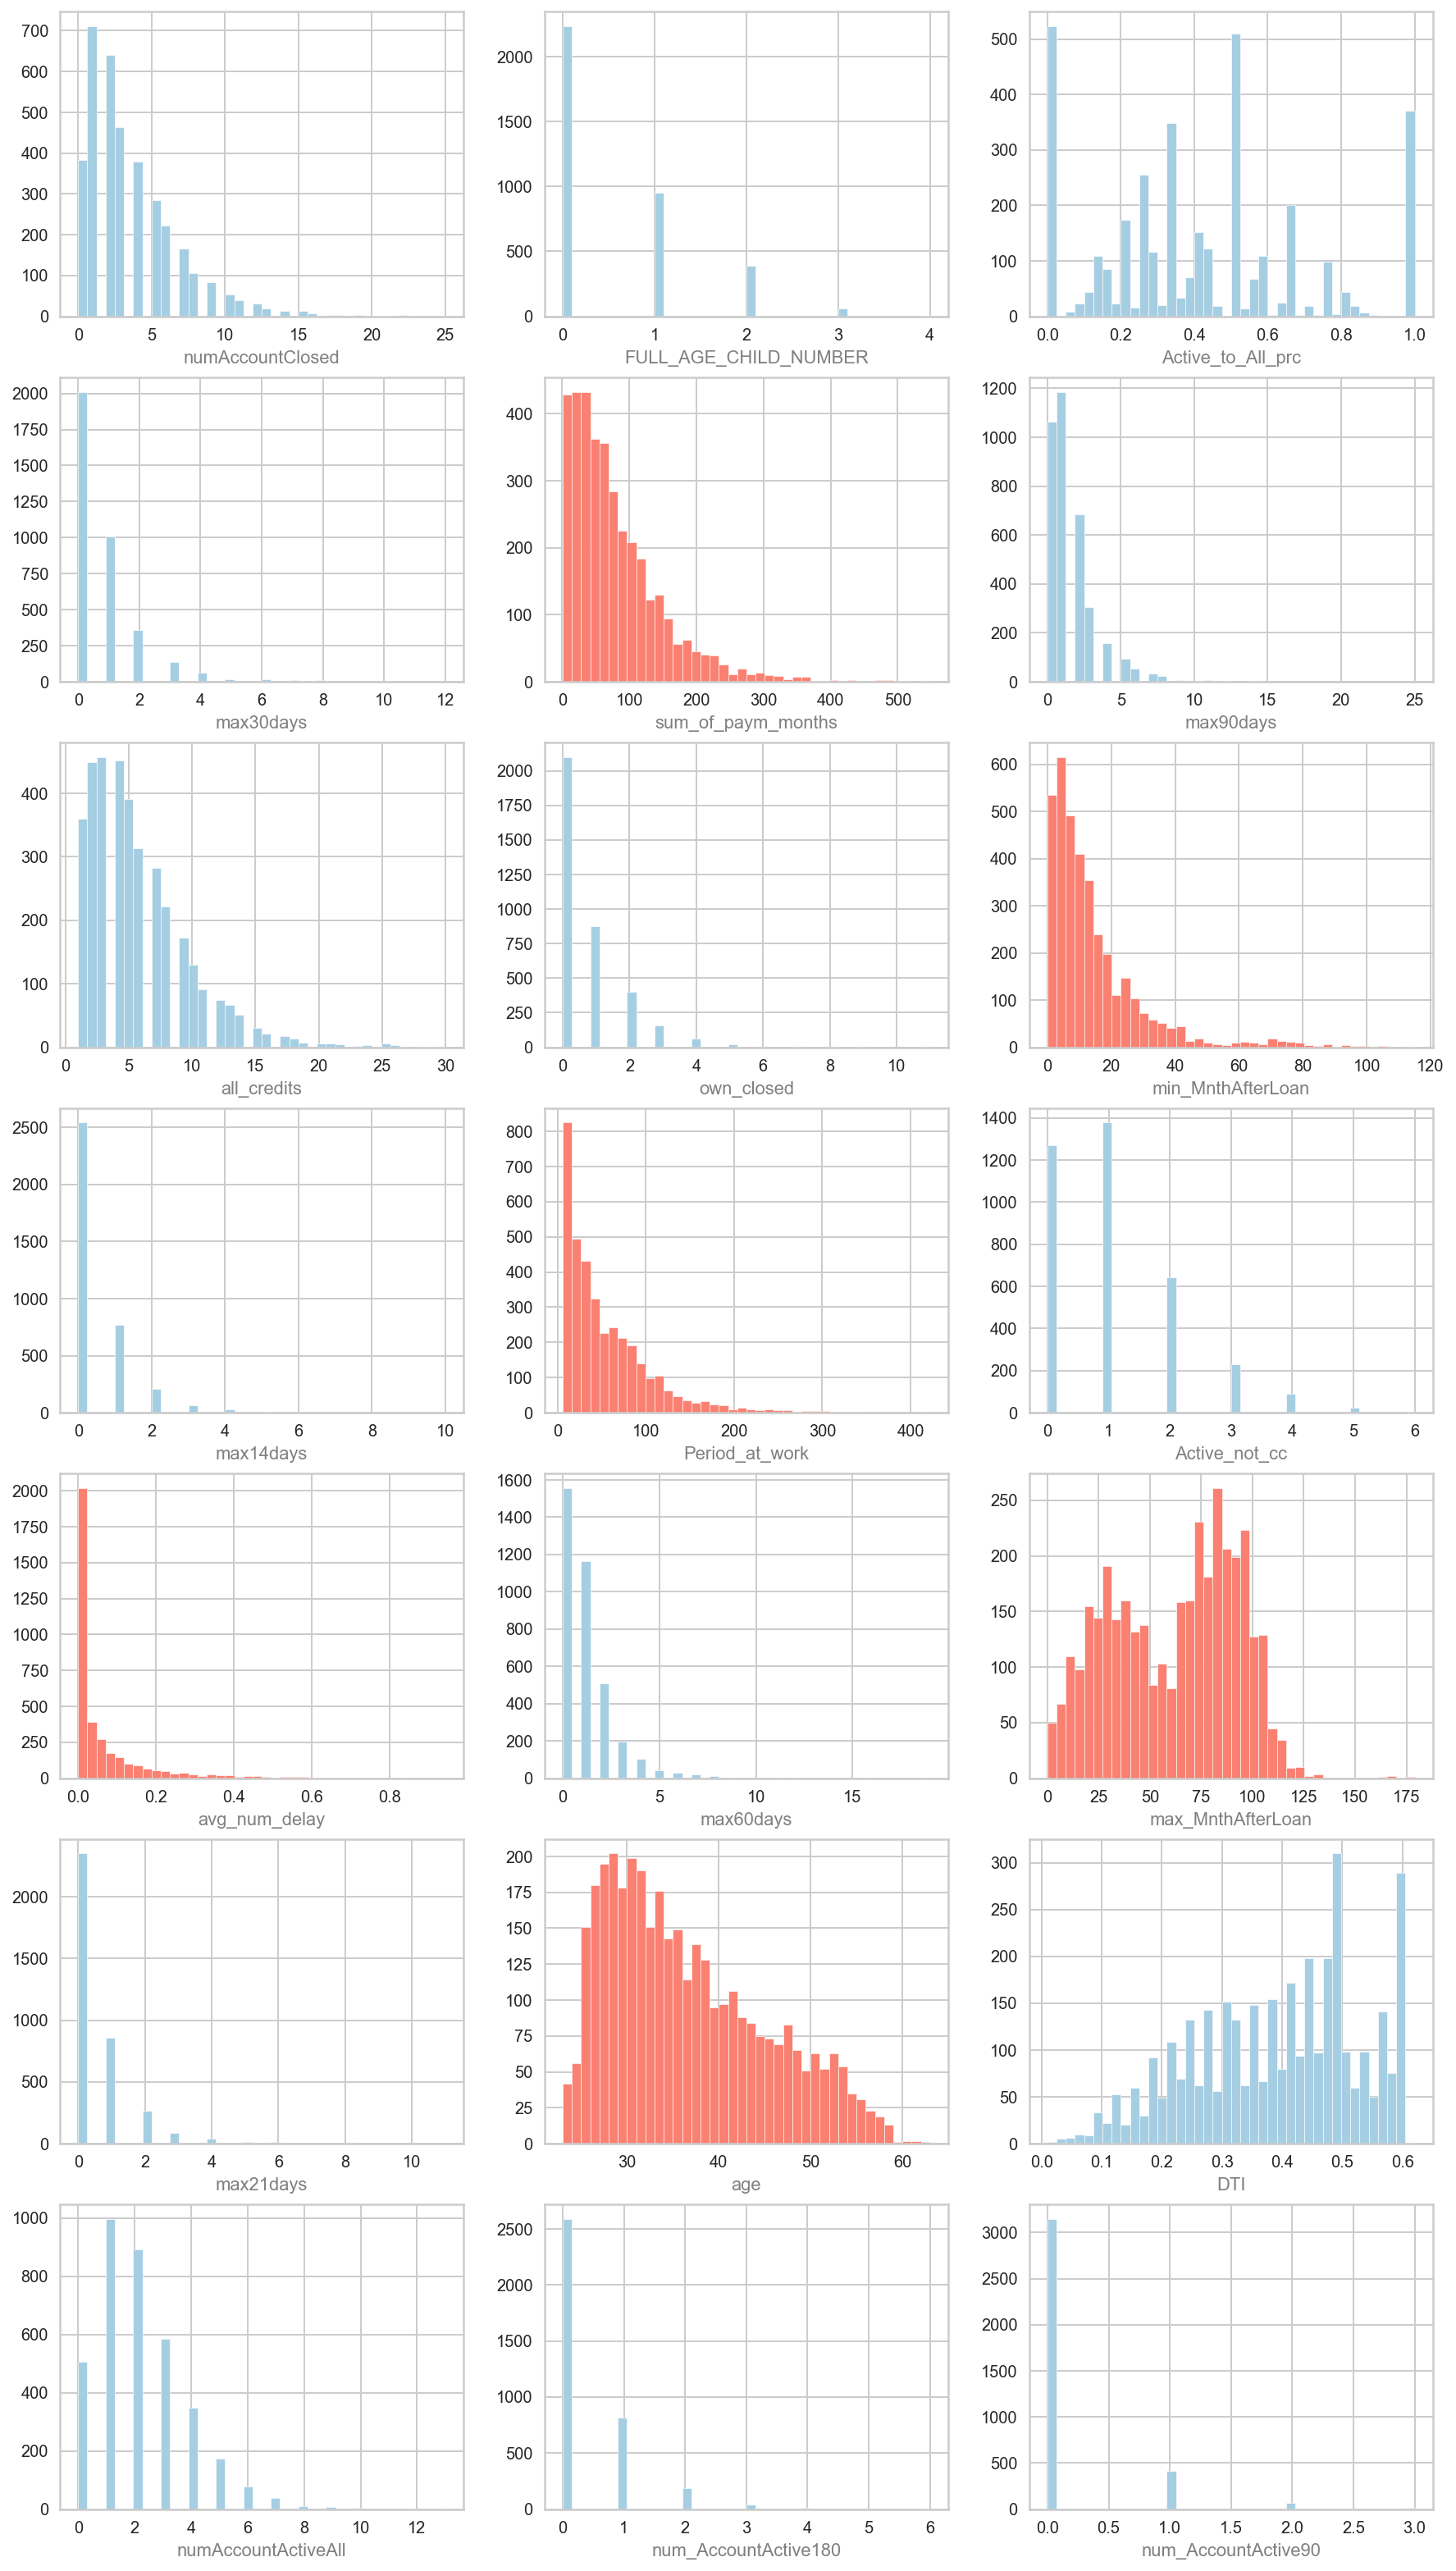

In [32]:
highlight = ['age', 'Period_at_work', 'max_MnthAfterLoan', 'avg_num_delay',
             'min_MnthAfterLoan', 'sum_of_paym_months']

def plot_hists(df, r, c, features):
    fig, axs = plt.subplots(r, c, figsize=(c*5, r*4))

    rows = np.arange(r)
    columns = np.arange(c)
    coords = np.meshgrid(rows, columns)
    
    for (i, j, k) in list(zip(coords[0].ravel(), coords[1].ravel(), features)):
        column = df[f'{k}']
        clr = 'salmon' if k in highlight else color
        axs[i, j].hist(column, bins=40, color=clr)
        axs[i, j].set_xlabel(k, color='grey')
        
plot_hists(df, 7, 3, num_feat)  

По гистограммам непрерывных признаков видно, что распределение некоторых переменных напоминает логнормальное (они выделены лососевым цветом): age, Period_at_work, avg_num_delay, min_MnthAfterLoan, sum_of_paym_months: у них тяжелый левый хвост и форма "горочкой". У признака max_MnthAfterLoan наблюдается бимодальность. Чтобы приблизить природу этих распределений к нормальному, попробуем взять от них логарифм и посмотреть на полученные гистограммы. Следует отметить, что в случае с дискретными переменными (max14days, FULL_AGE_CHILD_NUMBER и т.д.) логарифмирование не приведет к улучшениям.

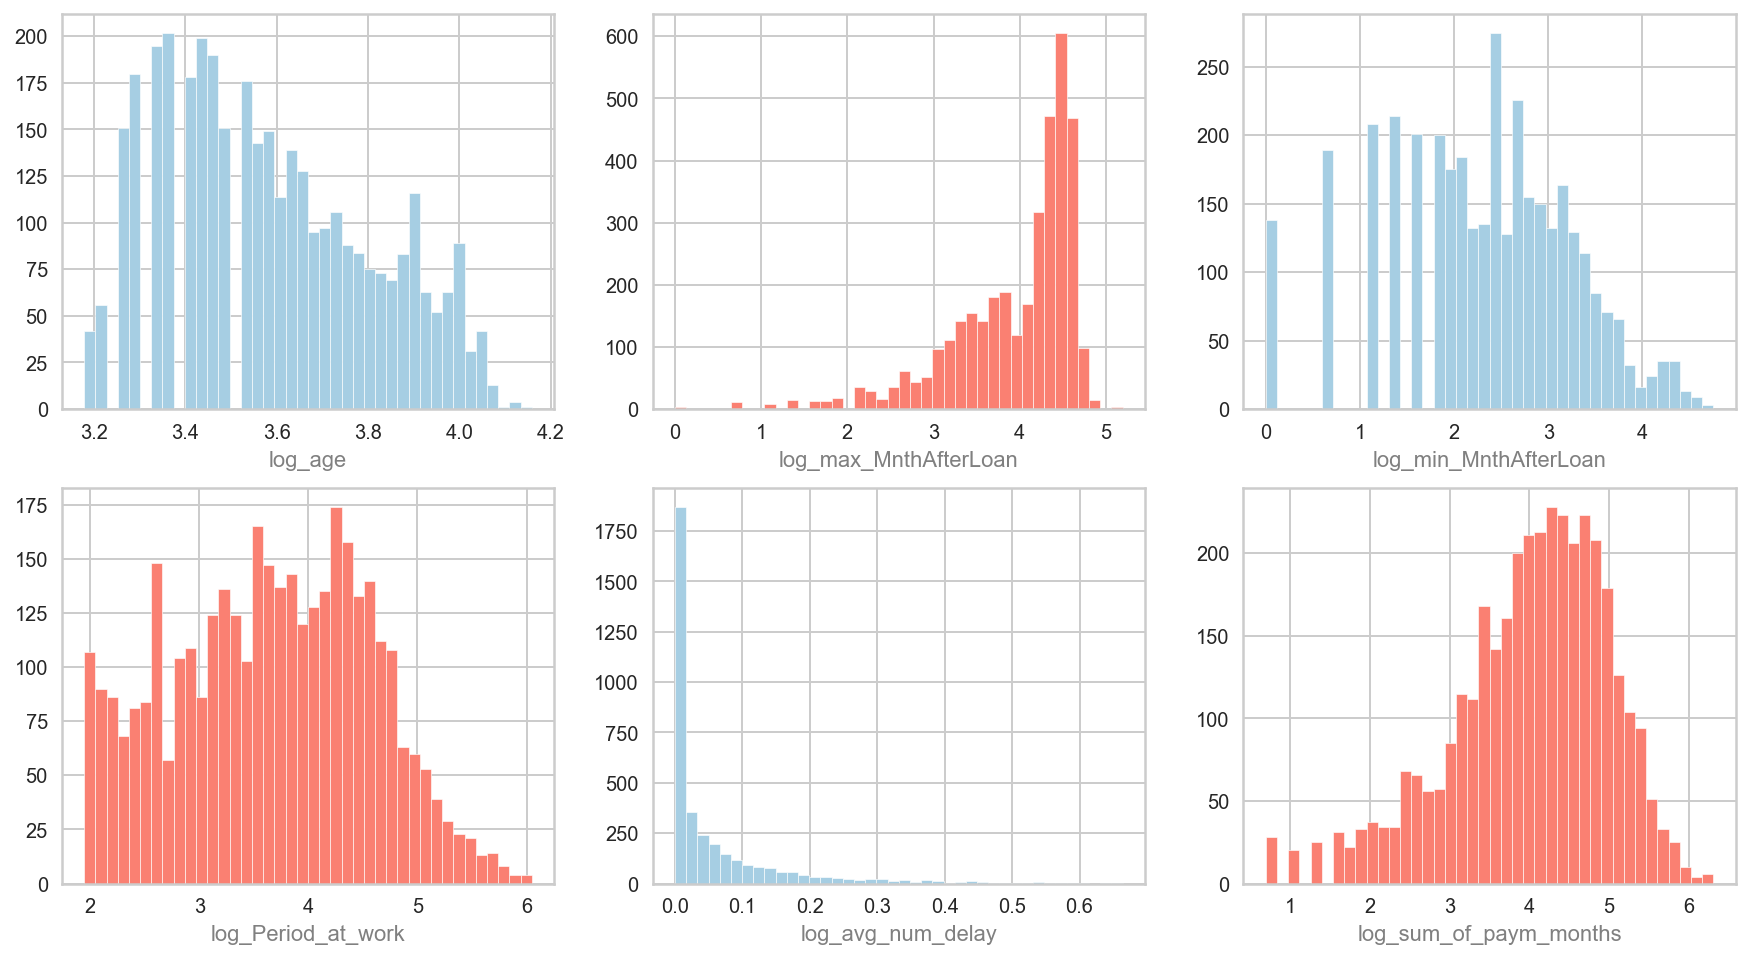

In [33]:
better = ['Period_at_work', 'max_MnthAfterLoan', 'sum_of_paym_months']

def plot_log_hists(df, r, c, features):
    fig, axs = plt.subplots(r, c, figsize=(c*5, r*4))

    rows = np.arange(r)
    columns = np.arange(c)
    coords = np.meshgrid(rows, columns)
    
    for (i, j, k) in list(zip(coords[0].ravel(), coords[1].ravel(), features)):
        column = np.log1p(df[f'{k}'])
        clr = 'salmon' if k in better else color
        axs[i, j].hist(column, bins=40, color=clr)
        axs[i, j].set_xlabel(f'log_{k}', color='grey')
        
plot_log_hists(df, 2, 3, highlight)  

Распределение переменных Period_at_work, max_MnthAfterLoan, sum_of_paym_months (выделены лососевым) действительно визуально приближается к нормальному. Эти признаки при подготовке итоговой витрины данных будут прологарифмированы. В остальных случаях преобразование не помогает: гистограмма или не меняется, или становится разреженной.

Теперь исследуем данные на выбросы с помощью ящичковых диаграмм.

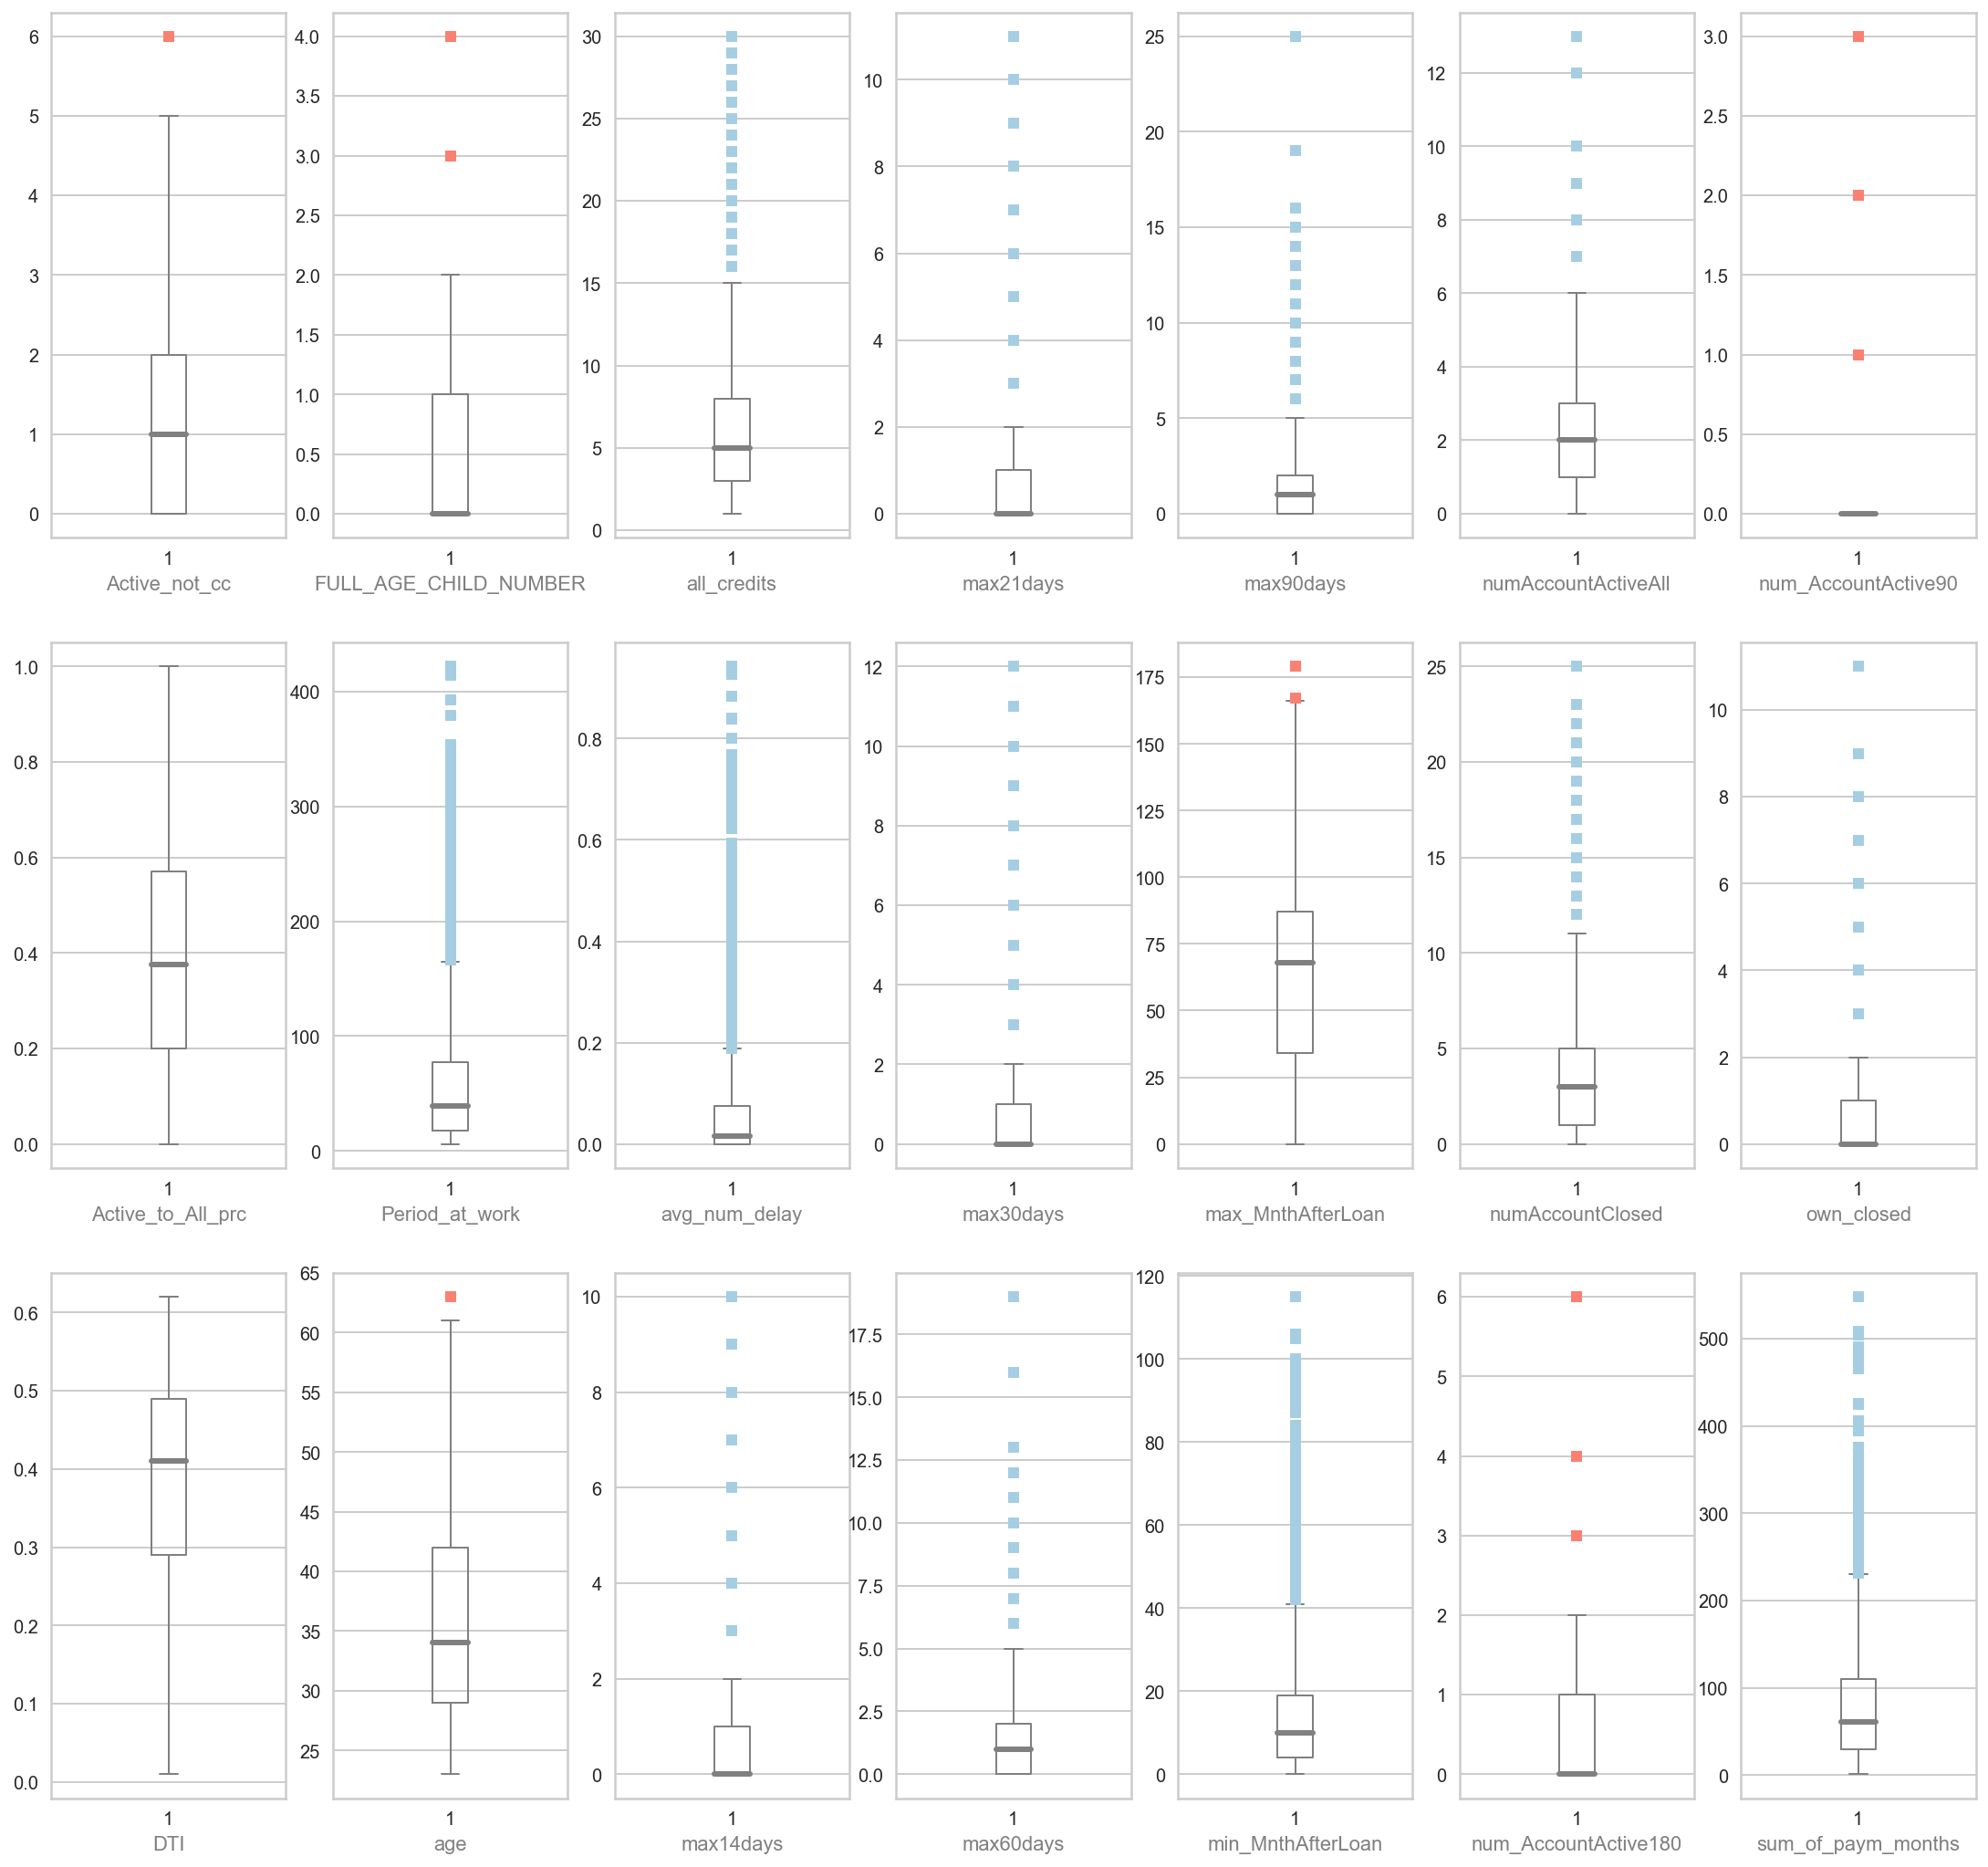

In [34]:
lst = ['age', 'num_AccountActive90', 'max_MnthAfterLoan',
       'num_AccountActive180', 'FULL_AGE_CHILD_NUMBER', 'Active_not_cc']

def plot_boxplots(df, r, c, features):
    fig, axs = plt.subplots(r, c, figsize=(c*2.7, r*6))

    rows = np.arange(r)
    columns = np.arange(c)
    coords = np.meshgrid(rows, columns)
    
    medianprops = dict(color='grey', linewidth=3)
    edgeprops = dict(color='grey')
    
    for (i, j, k) in list(zip(coords[0].ravel(), coords[1].ravel(), features)):
        column = df[f'{k}']
        clr = 'salmon' if k in lst else color
        flierprops = dict(marker='s', markerfacecolor=clr, markeredgecolor='none')
        axs[i, j].boxplot(column,
                          flierprops=flierprops,
                          medianprops=medianprops,
                          boxprops=edgeprops,
                          whiskerprops=edgeprops,
                          capprops=edgeprops)
        axs[i, j].set_xlabel(k, color='grey')
        axs[i, j].grid(visible=False, axis='x', which='both')
        
plot_boxplots(df, 3, 7, sorted(num_feat))

Голубым цветом выделены объекты, которые находятся выше "усов" из-за большой дисперсии. Лососевым - объекты, которые визуально действительно напоминают выбросы. Удалим этих клиентов, а именно тех, у которых:
<ul>
    <li>возраст (age) более 61 года</li>
    <li>количество активных аккаунтов за последние 90 дней (num_AccountActive90) больше 1</li>
    <li>число месяцев, прошедших с первого кредита (max_MnthAfterLoan) больше 160</li>
    <li>количество активных аккаунтов за последние 180 дней (num_AccountActive180) больше 2</li>
    <li>количество детей (FULL_AGE_CHILD_NUMBER) больше 2</li>
    <li>количество действующих аккаунтов без кредитных карт (Active_not_cc) больше 5</li>
</ul>    

In [35]:
df = df[(df.age <= 61) &
        (df.num_AccountActive90 <= 1) &
        (df.max_MnthAfterLoan <= 160) &
        (df.num_AccountActive180 <= 2) &
        (df.FULL_AGE_CHILD_NUMBER <= 2) &
        (df.Active_not_cc <= 5)]

In [36]:
df.shape

(3471, 35)

Получилось, что удалено примерно 4% выборки - это приемлемая доля для выбросов.

После очистки данных посмотрим на описательные статистики.

In [37]:
stats = df[num_feat].agg(['describe']).T
(stats.style.background_gradient(subset=['mean', 'min', '25%', '50%', '75%', 'max'], axis=1, cmap='Blues')
 .format('{:.2f}'))

,,count,mean,std,min,25%,50%,75%,max
numAccountClosed,describe,3471.00,3.48,3.16,0.00,1.00,3.00,5.00,25.00
max30days,describe,3471.00,0.74,1.17,0.00,0.00,0.00,1.00,11.00
all_credits,describe,3471.00,5.54,3.91,1.00,3.00,5.00,7.00,30.00
max14days,describe,3471.00,0.45,0.89,0.00,0.00,0.00,1.00,10.00
avg_num_delay,describe,3471.00,0.07,0.12,0.00,0.00,0.01,0.08,0.94
max21days,describe,3471.00,0.55,0.99,0.00,0.00,0.00,1.00,10.00
numAccountActiveAll,describe,3471.00,2.06,1.60,0.00,1.00,2.00,3.00,12.00
FULL_AGE_CHILD_NUMBER,describe,3471.00,0.48,0.68,0.00,0.00,0.00,1.00,2.00
sum_of_paym_months,describe,3471.00,79.05,68.29,1.00,30.00,61.00,109.00,508.00
own_closed,describe,3471.00,0.71,1.08,0.00,0.00,0.00,1.00,9.00


Аномалий в данных нет: минимальные и максимальные значения соответствуют природе каждого признака. У большинства переменных ненулевая медиана, а значит признаки достаточно "насыщенные".

Как было видно еще на ящичковых диаграммах, у нескольких переменных большая дисперсия, особенно у Period_at_work, avg_num_delay, min_MnthAfterLoan, sum_of_paym_months. С точки зрения кластеризации это можно принять и за преимущество, и за недостаток: с одной стороны, по таким признакам проще разделить объекты, с другой - сложнее объединить похожие.

У нескольких переменных среднее значение меньше единицы. Это проблема с точки зрения интерпретации: например, "у клиентов в среднем 0,71 закрытый аккаунт" звучит недостаточно информативно. Гораздо удобнее перевести все такие признаки в бинарные: 1 - наличие характеристики, 0 - отсутствие. В этом случае значения будут интерпретироваться как доли клиентов с определенной характеристикой среди всех клиентов. Например, "доля клиентов, у которых есть закрытые аккаунты, равна ...". Переведем из числовых в категориальных следующие переменные:
<ul>
    <li>max14days</li>
    <li>max21days</li>
    <li>FULL_AGE_CHILD_NUMBER</li>
    <li>own_closed</li>
    <li>num_AccountActive180</li>
    <li>max30days</li>
</ul>

In [38]:
def convert_feature(df, feature):
    df[f'{feature}'] = np.where(df[f'{feature}'] >= 1, 1, 0)
    return df

new_cat = ['max14days', 'max21days', 'FULL_AGE_CHILD_NUMBER',
           'own_closed', 'num_AccountActive180', 'max30days']
for i in new_cat:
    df = convert_feature(df, i)

In [39]:
cat_feat = cat_feat + new_cat + ['num_AccountActive90']
for i in new_cat:
    num_feat.remove(i)
num_feat.remove('num_AccountActive90')

len(num_feat) + len(cat_feat) == df.shape[1]

True

**Исследование категориальных переменных**

Для каждой категориальной переменной нарисуем столбчатый график, чтобы визуализировать категории и выявить незначительные. Незначительными по умолчанию назовем те, которые составляют менее 2% значений признака (будут выделены лососевым цветом). Сильно повышать порог незначительности не стоит: это может привести к чрезмерному "выравниванию" объектов, что затруднит выявление четких сегментов.

Сначала рассмотрим переменные с текстовыми категориями, затем бинарные (0/1).

In [1]:
def get_other_color(data, df, ax):
    for i in df.index:
        if df.loc[i] / len(data) < 0.02:
            ax.patches[df.index.get_indexer([f'{i}'])[0]].set_facecolor('salmon')
    return ax

def plot_barcharts(n, indx, df, features):   
    fig, axs = plt.subplots(n, figsize=(7, n*4.5))
    
    for (i, feature) in list(zip(range(n), features)):
        df_group = df.groupby(feature).count()['numAccountActiveAll']

        if indx == 'float':
            opts = list(map(int, list(df_group.index)))
        else:
            opts = list(df_group.index)

        freq = df_group / sum(df_group) * 100
        y_pos = np.arange(len(opts))
        
        axs[i].barh(y_pos, freq, color=color, align='center')
        get_other_color(df, df_group, axs[i])
        
        for u, v in enumerate(freq):
            clr = 'salmon' if v < 2 else color
            axs[i].text(v + 2, u + 0.15, str(round(v, 2))+'%', color=clr, fontweight='bold')
        
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(opts)
        axs[i].invert_yaxis()
        axs[i].set_xlim(0, 100)
        axs[i].set_xlabel('% of values', color='grey')
        axs[i].set_ylabel(feature, color='grey')
        axs[i].grid(color='whitesmoke')

    plt.show()

In [ ]:
str_feat = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'SEX',
            'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE',
            'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS']

plot_barcharts(len(str_feat), 'str', df, str_feat)

По графикам заметно, что некоторые категории можно объединить, а некоторые - удалить, если в них практически нет наблюдений:
<ul>
    <li>у переменной CREDIT_PURPOSE категории "Лечение", "Обучение" и "Отпуск" объединим в одну - "Нематериальные нужды"; категории "Покупка бытовой техники" и "Покупка мебели" - в "Покупку бытовой техники/мебели" (все это относится к относительно крупным покупкам для дома); "Покупка земли" и "Покупка недвижимости/ строительство" - в "Покупку недвижимости/земли"</li>
    <li>у переменной EDUCATION объединим "Высшее/Второе высшее/Ученая степень" и "второе высшее" в категорию "Второе высшее/Ученая степень", а категорию "ученая степень" удалим</li>
    <li>у переменной EMPL_PROPERTY удалим категории "Сельское и лесное хозяйство" и "Юридические услуги"</li>
    <li>у переменной FAMILY_STATUS отнесем категории "разведен / разведена" и "гражданский брак" к "холост / не замужем" (если человек разведен, то он, очевидно, не женат/не замужем; гражданским браком в России очень часто по неграмотности называют сожительство, которое браком не является); категорию "повторный брак" отнесем к "женат / замужем"; категорию "вдовец / вдова" удалим</li>
</ul>    

In [42]:
# Цель кредита
df.CREDIT_PURPOSE = np.where(((df.CREDIT_PURPOSE=='Лечение') |
                              (df.CREDIT_PURPOSE=='Обучение') |
                              (df.CREDIT_PURPOSE=='Отпуск')), 'Нематериальные нужды',
                             
                             np.where(((df.CREDIT_PURPOSE=='Покупка бытовой техники') |
                                       (df.CREDIT_PURPOSE=='Покупка мебели')),
                                      'Покупка бытовой техники/мебели',
                                      
                                      np.where(((df.CREDIT_PURPOSE=='Покупка земли') |
                                                (df.CREDIT_PURPOSE=='Покупка недвижимости/ строительство')),
                                               'Покупка недвижимости/земли', df.CREDIT_PURPOSE)))

# Образование
df.EDUCATION = np.where(((df.EDUCATION=='Высшее/Второе высшее/Ученая степень') |
                         (df.EDUCATION=='второе высшее')),
                        'Второе высшее/Ученая степень', df.EDUCATION)

df = df[df.EDUCATION != 'ученая степень']

# Отрасль
df = df[(df.EMPL_PROPERTY != 'Сельское и лесное хозяйство') &
        (df.EMPL_PROPERTY != 'Юридические услуги')]

# Семейное положение
df.FAMILY_STATUS = np.where(((df.FAMILY_STATUS=='разведен / разведена') |
                             (df.FAMILY_STATUS=='гражданский брак')), 'холост / не замужем',
                            
                            np.where(df.FAMILY_STATUS=='повторный брак', 'женат / замужем',
                                     df.FAMILY_STATUS))

df = df[(df.FAMILY_STATUS != 'вдовец / вдова')]

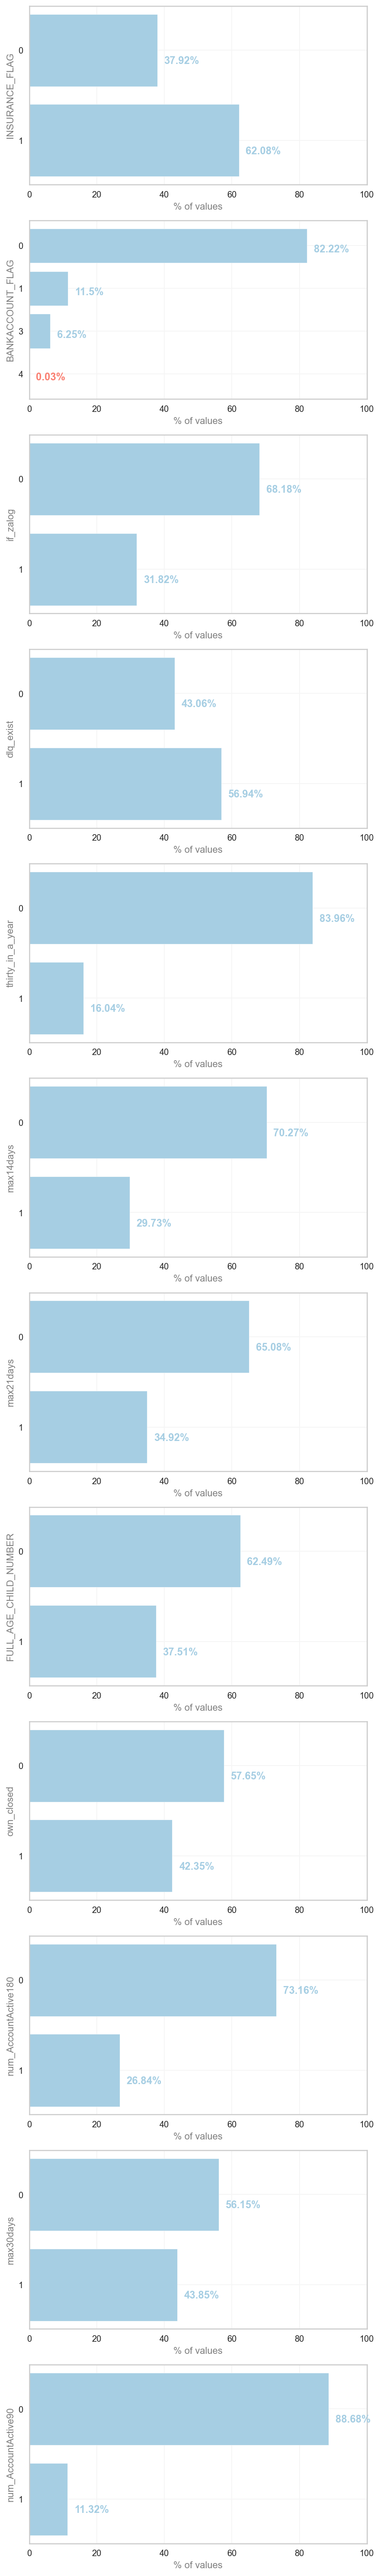

In [43]:
float_feat = (['INSURANCE_FLAG', 'BANKACCOUNT_FLAG', 'if_zalog', 'dlq_exist', 'thirty_in_a_year'] +
              new_cat + ['num_AccountActive90'])

plot_barcharts(len(float_feat), 'float', df, float_feat)

Все переменные достаточно сбалансированные. Единственное исключение - BANKACCOUNT_FLAG: она принимает значение 0, если у клиента нет онлайн аккаунта, 1, если есть один, 2 или более, если у клиента есть доступ к аккаунту с нескольких устройств. Согласно графику, логично преобразовать этот признак в бинарный: 0, если у клиента нет аккаунта, 1 - если есть.

In [44]:
df['BANKACCOUNT_FLAG'] = np.where(df.BANKACCOUNT_FLAG >= 3, 1, df.BANKACCOUNT_FLAG)

Посмотрим на количество числовых и категориальных признаков.

In [45]:
print('Числовых признаков:', len(num_feat))
print('Категориальных признаков:', len(cat_feat))

Числовых признаков: 14
Категориальных признаков: 21


Число и тех, и других переменных уменьшилось после обработки данных. Теперь посмотрим, насколько изменилось количество классов в каждой категориальной переменной, так как от этого зависит число признаков в итоговой витрине данных.

In [46]:
describe_cat_feat(df, cat_feat)

,Уникальные значения,Число уникальных значений
dlq_exist,"0.0, 1.0",2
EMPL_PROPERTY,"Другое, Информационные технологии, Торговля",3
INSURANCE_FLAG,"0.0, 1.0",2
CREDIT_PURPOSE,"Другое, Нематериальные нужды, Покупка автомобиля, Покупка бытовой техники/мебели, Покупка недвижимости/земли, Ремонт",6
thirty_in_a_year,"0.0, 1.0",2
if_zalog,"0.0, 1.0",2
SEX,"женский, мужской",2
BANKACCOUNT_FLAG,"0.0, 1.0",2
INCOME_BASE_TYPE,"2НДФЛ, Поступление зарплаты на счет, Свободная форма с печатью работодателя, Форма банка (без печати работодателя)",4
EMPL_TYPE,"вспомогательный персонал, менеджер высшего звена, менеджер по продажам, менеджер среднего звена, рабочий, специалист, торговый представитель",7


In [47]:
describe_cat_feat(df, cat_feat)['Число уникальных значений'].sum() - len(cat_feat)

40

Число уникальных значений уменьшилось по сравнению с "сырыми" данными, при этом качество признаков не ухудшилось, так как были удалены и объединены столбцы и классы, которые только увеличивали размерность.

Исследуем данные на корреляцию между переменными (столбец fictive_feat добавим для того чтобы значения на графике были от -1 до 1 и распределение цвета было корректным).

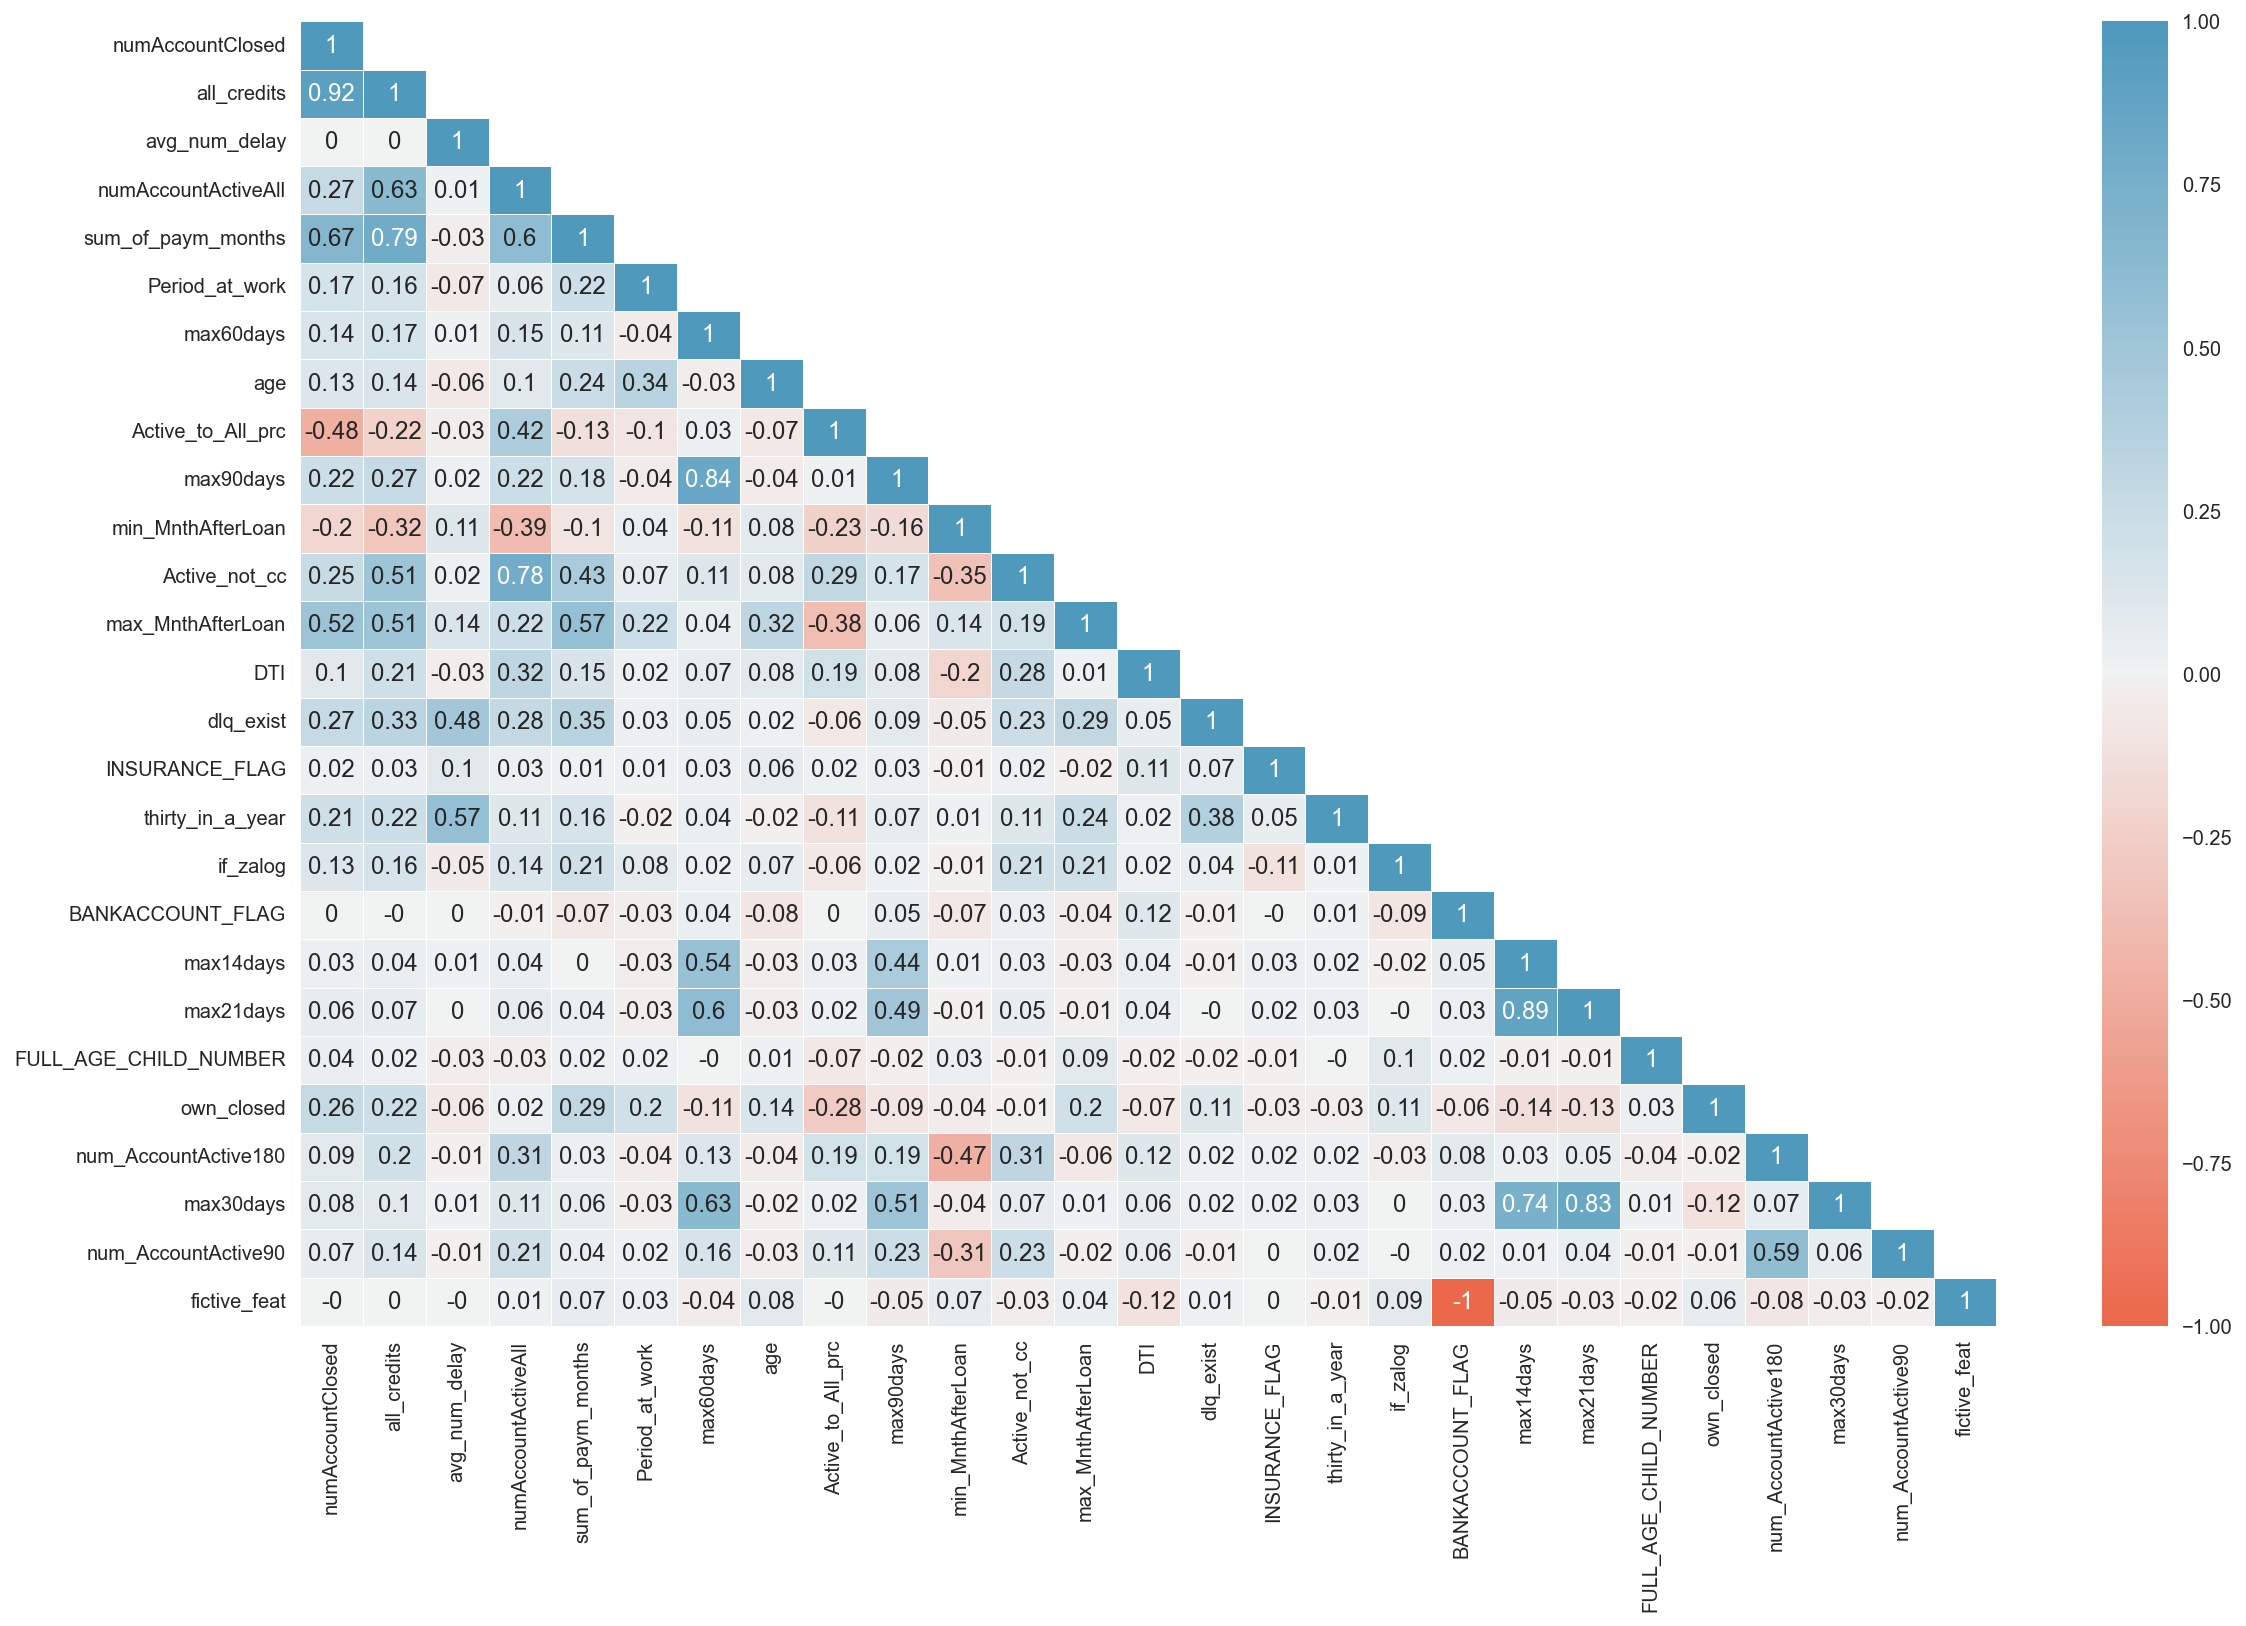

In [48]:
df['fictive_feat'] = np.where(df.BANKACCOUNT_FLAG == 1, 0, 1)

corr = np.round(df[num_feat + cat_feat + ['fictive_feat']].corr(), 2)
cmap = sns.diverging_palette(19, 230, l=60, as_cmap=True)
antimask = np.tri(len(corr))
mask = np.absolute(antimask - np.ones((corr.shape[0], corr.shape[0])))

plt.subplots(figsize = (19, 12))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5, cmap=cmap);

В целом корреляция между признаками низкая. Очевидные исключения - переменные, которые не могут быть не связаны друг с другом. Например, max14days, max21days и max30days попарно линейно связаны друг с другом довольно сильно, так как каждый из этих признаков может включать другой.

In [49]:
df.drop(columns=['fictive_feat'], axis=1, inplace=True)
df = df.convert_dtypes()

## 2. Подготовка витрины данных ##

Преобразуем данные и подготовим итоговую витрину:
<ul>
    <li>признаки Period_at_work, max_MnthAfterLoan, sum_of_paym_months логарифмируем, остальные числовые переменные оставим без изменений</li>
    <li>категориальные признаки закодируем с помощью one-hot-encoding</li>
<ul>

In [50]:
def get_logarithms(df, feature):
    df[f'log_{feature}'] = np.log1p(df[f'{feature}'])
    return df

for i in better:
    df = get_logarithms(df, i)
    
log_feat = ['log_Period_at_work', 'log_max_MnthAfterLoan', 'log_sum_of_paym_months']

In [51]:
def ohe_preprocess(df, feature):
    return ((pd.get_dummies(df[f'{feature}']).T).iloc[:-1]).T

In [52]:
dm = pd.concat([df[list(set(num_feat) - set(better))],
                df[log_feat],
                df[float_feat],
                pd.concat([ohe_preprocess(df, i) for i in str_feat], axis=1)], axis=1)

In [53]:
dm.head(10)

,numAccountClosed,age,all_credits,Active_to_All_prc,max90days,min_MnthAfterLoan,numAccountActiveAll,avg_num_delay,Active_not_cc,DTI,max60days,log_Period_at_work,log_max_MnthAfterLoan,log_sum_of_paym_months,INSURANCE_FLAG,BANKACCOUNT_FLAG,if_zalog,dlq_exist,thirty_in_a_year,max14days,max21days,FULL_AGE_CHILD_NUMBER,own_closed,num_AccountActive180,max30days,num_AccountActive90,2НДФЛ,Поступление зарплаты на счет,Свободная форма с печатью работодателя,Другое,Нематериальные нужды,Покупка автомобиля,Покупка бытовой техники/мебели,Покупка недвижимости/земли,женский,Второе высшее/Ученая степень,высшее,незаконченное высшее,среднее,вспомогательный персонал,менеджер высшего звена,менеджер по продажам,менеджер среднего звена,рабочий,специалист,< 50,Другое,Информационные технологии,Государственное предприятие,ЗАО,Иная форма,Индивидуальный предприниматель,ОАО,женат / замужем
4,5,31,10,0.5,0,27,5,0.023333,1,0.43,0,4.043051,4.51086,5.68358,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
6,2,47,4,0.25,0,42,2,0.180645,1,0.46,0,4.248495,4.394449,4.85203,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
8,3,52,7,0.428571,1,5,4,0.046784,2,0.35,1,5.087596,4.442651,5.099866,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
13,4,28,6,0.333333,4,7,2,0.03125,1,0.23,3,2.944439,3.663562,4.143135,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1
16,1,23,1,0.0,0,37,0,0.0,0,0.23,0,3.828641,3.637586,3.637586,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
17,2,37,4,0.5,6,2,2,0.016129,1,0.19,3,4.007333,3.850148,4.127134,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
23,1,52,2,0.0,0,41,1,0.060606,1,0.24,0,5.17615,4.26268,3.465736,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
24,7,35,9,0.222222,2,10,2,0.041667,1,0.59,2,3.332205,4.26268,4.934474,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
26,2,33,7,0.714286,0,3,5,0.0,3,0.54,0,3.178054,3.367296,4.110874,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,1,36,3,0.666667,1,4,2,0.0,1,0.3,0,3.78419,2.639057,2.772589,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [54]:
dm.shape

(3391, 54)

В итоговой витрине данных получился 3391 объект и 54 признака. Использовать PCA (метод главных компонент) на данном этапе не имеет смысла, потому что размерность датасета не столь велика. Тем не менее если выбранные в дальнейшем методы сегментации потребуют уменьшить размерность, это будет сделано.

## 3. Сегментация ##

Условно методы сегментации можно разделить на "инженерные" (например, кластеризация с учителем или без учителя) и бизнес-подходы (бизнес-правила, RFM-сегментация и пр.). Попробуем использовать по одному алгоритму из каждой категории: метод K-Means (кластеризацию без учителя) и RFM-сегментацию, так как они наиболее популярны.

### 3.1 Метод K-Means ###

<b>Преимущества метода:</b>
<ul>
    <li>сравнительно быстрый: линейная сложность O(n) - это преимущество, скорее, перед другими алгоритмами обучения без учителя (DBSCAN и иерархическая кластеризация); это облегчает работу с данными большой размерности</li>
    <li>из параметров требует только число кластеров - это явное преимущество перед, например, DBSCAN, где нужно задавать расстояние и минимальное количество точек, что гораздо сложнее</li>
    <li>в отличие от бизнес-подходов использует все признаки и выбирает оптимальные кластеры исходя из полного набора данных</li>
</ul>


<b>Недостатки метода:</b>
<ul>
    <li>чувствителен к выбросам (тем не менее данные от них очищены)</li>
    <li>требует задания оптимального количества кластеров, что является отдельной исследовательской проблемой, несмотря на то что есть методы, которые позволяют определить это число заранее: сегменты могут получиться несбалансированными</li>
    <li>результат зависит от начальных центров, которые задаются случайным образом</li>
</ul>

Для начала определим количество кластеров с помощью метода локтя.

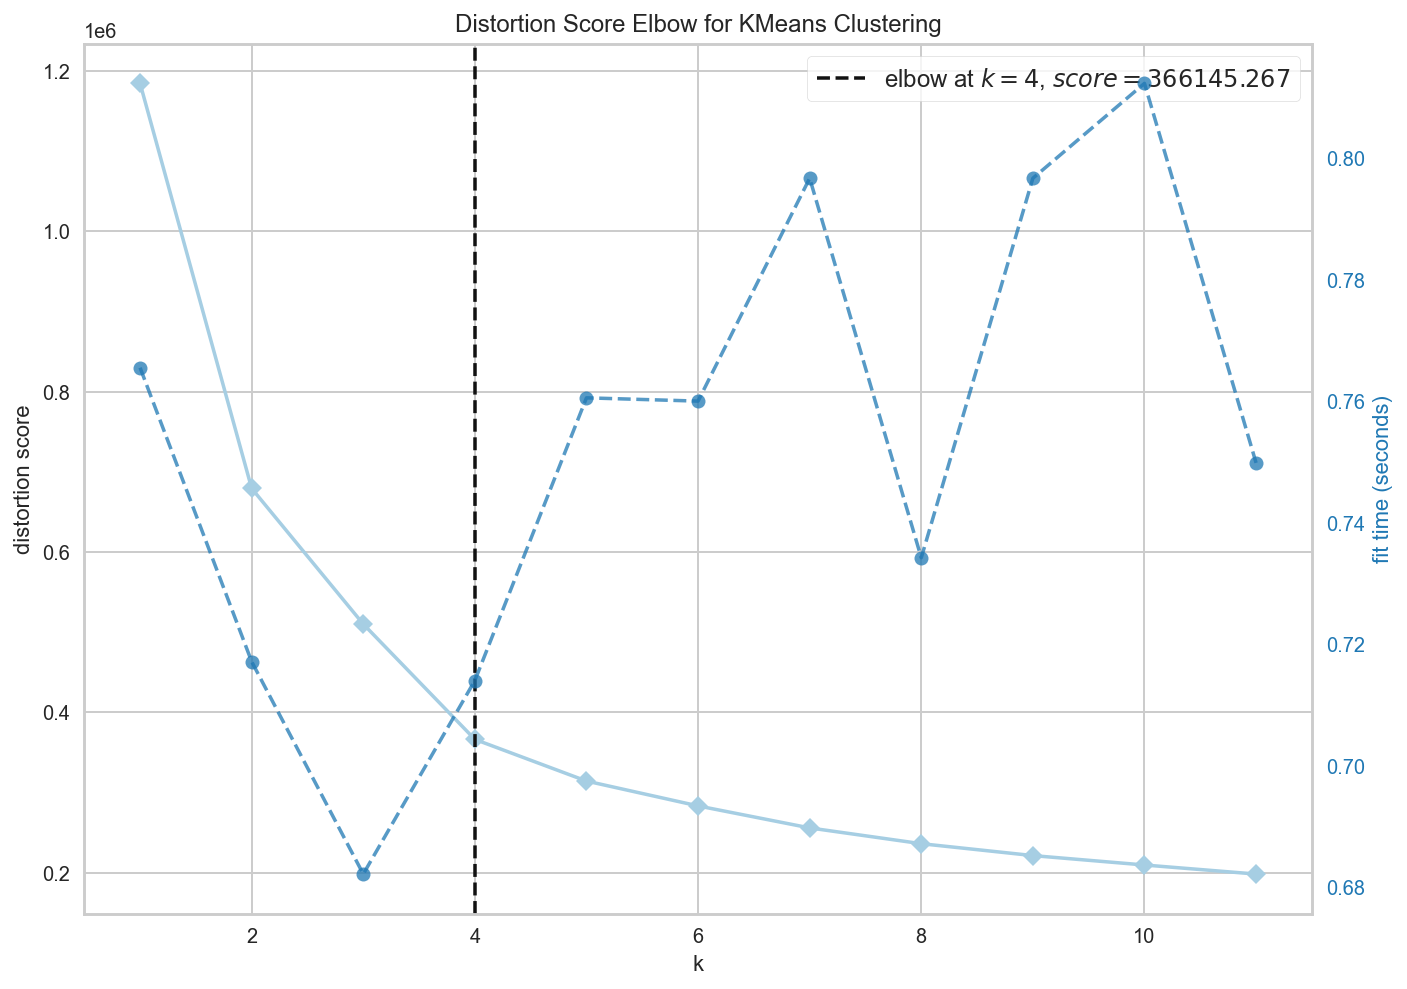

In [55]:
model = KMeans()
fig, ax = plt.subplots(figsize=(11, 8))
set_palette('paired')
visualizer = KElbowVisualizer(model, k=(1,12), ax=ax)

visualizer.fit(dm)
visualizer.show();
# если с библиотекой yellowbricks проблемы, скриншот графика есть в архиве

Итак, оптимальное число кластеров - 4.

Используем трансформер, который масштабирует (стандартизирует) данные, а потом применяет метод K-Means.

In [56]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), list(set(num_feat) - set(better)) + log_feat)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('clustering', KMeans(n_clusters=4, init='k-means++'))
])

df['cluster'] = pipeline.fit_predict(dm)

Посмотрим на соотношение размеров кластеров:

In [57]:
np.round(df.groupby('cluster').count()['all_credits'] / len(df) * 100, 2)

cluster
0    29.40
1    34.50
2    20.02
3    16.07
Name: all_credits, dtype: float64

Кластеры получились достаточно сбалансированными.

Выведем описательные статистики для числовых переменных в каждом кластере и моду для каждого категориального признака, а затем опишем полученные сегменты на основе этой информации.

In [58]:
def describe_numeric(df, cluster):
    agg = df[df.cluster==cluster][num_feat].agg(['min', 'mean', 'max'])
    agg['cluster'] = np.full(len(agg), cluster)
    return agg

In [59]:
numeric = pd.concat([describe_numeric(df, i) for i in sorted(pd.unique(df.cluster.values))])
numeric['stat'] = numeric.index
numeric.set_index(['cluster', 'stat'], inplace=True)
numeric = numeric.transpose()

numeric.style.background_gradient(axis=1, cmap='Blues').format('{:.2f}')

In [60]:
def describe_cat(df, feature, compare, column):   
    cat = pd.concat([df[df[f'{feature}']==i][cat_feat+float_feat].agg(pd.Series.mode)
                     for i in sorted(pd.unique(df[f'{feature}'].values))]).T

    cat.columns = sorted(pd.unique(df[f'{feature}'].values))
    
    if feature=='cluster':
        cat['common'] = ((cat[0] == cat[1]) & (cat[1] == cat[2]) & (cat[2] == cat[3]))
    else: 
        cat['common'] = ((cat['VIP'] == cat['Дрейфующие']) & (cat['Дрейфующие'] == cat['Лояльные']) &
                         (cat['Лояльные'] == cat['Отток']) & (cat['Отток'] == cat['Риск оттока']) &
                         (cat['Риск оттока'] == cat['Спящие']))
    
    cat['index'] = cat.index
    cat.drop_duplicates(subset='index', inplace=True)

    if compare == 'common':
        return cat[cat.common == True][column]
    else:
        return cat[cat.common == False].drop(columns=['common', 'index'])

In [61]:
describe_cat(df, 'cluster', 'common', 0)

EMPL_PROPERTY                   Торговля
INSURANCE_FLAG                         1
CREDIT_PURPOSE                    Ремонт
thirty_in_a_year                       0
if_zalog                               0
BANKACCOUNT_FLAG                       0
EMPL_TYPE                     специалист
EMPL_FORM                            ООО
EMPL_SIZE                           >250
FAMILY_STATUS            женат / замужем
EDUCATION                         высшее
max14days                              0
FULL_AGE_CHILD_NUMBER                  0
num_AccountActive180                   0
num_AccountActive90                    0
Name: 0, dtype: object

In [62]:
describe_cat(df, 'cluster', 'different', 0)

,0,1,2,3
dlq_exist,0,1,0,1
SEX,мужской,мужской,женский,мужской
INCOME_BASE_TYPE,Поступление зарплаты на счет,Поступление зарплаты на счет,Поступление зарплаты на счет,Форма банка (без печати работодателя)
max21days,0,0,0,1
own_closed,0,0,0,1
max30days,0,0,0,1


<b>Типичный представитель каждого сегмента:</b>
<ul>
    <li>женат или замужем, без совершеннолетних детей, имеет высшее образование</li>
    <li>работает в ООО в сфере торговли, получает зарплату более 250 тыс. рублей</li>
    <li>берет кредит на ремонт без залога, страхует его</li>
    <li>не имеет онлайн-аккаунта и активных аккаунтов за последние 180 дней, не обращался в кредитные бюро за последние две недели</li>
    <li>не имеет просрочек за последние 30 дней</li>
</ul>    

<b>Сегмент 1 "Серый мышонок"</b>
<ul>
    <li>мужчина, 36 лет</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатил по кредитам 50 тыс. рублей</li>
    <li>не обращался в кредитные бюро за последние 30 дней; за последние 90 дней обратился 1 раз</li>
    <li>не имеет задолженностей</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет один активный счет или 17% среди всех счетов</li>
    <li>свой первый кредит взял 5 лет назад, последний - 2 года назад</li>
</ul>

<b>Сегмент 2 "Заядлый заемщик"</b>
<ul>
    <li>мужчина, 37 лет</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатил по кредитам 92 тыс. рублей</li>
    <li>не обращался в кредитные бюро за последние 30 дней; за последние 90 дней обратился 1 раз</li>
    <li>имеет задолженность</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 3 активных счета или 46% среди всех счетов</li>
    <li>свой первый кредит взял 6 лет назад, последний - меньше года назад</li>
</ul>

<b>Сегмент 3 "Большая шишка"</b>
<ul>
    <li>мужчина, 38 лет</li>
    <li>работает менеджером среднего звена, имеет форму банка без печати работодателя</li>
    <li>за последний месяц выплатил по кредитам 167 тыс. рублей</li>
    <li>обращался в кредитные бюро за последние 3 недели; за последние 90 дней обратился 3 раза</li>
    <li>имеет задолженность</li>
    <li>имеет погашенные кредиты</li>
    <li>имеет 4 активных счета или 32% среди всех счетов</li>
    <li>свой первый кредит взял 7 лет назад, последний - меньше года назад</li>
</ul>

<b>Сегмент 4 "Начинающая"</b>
<ul>
    <li>женщина, 32 года</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатила по кредитам 23 тыс. рублей</li>
    <li>не обращалась в кредитные бюро за последние 30 дней; за последние 90 дней обратилась 1 раз</li>
    <li>не имеет задолженность</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 2 активных счета или 74% среди всех счетов</li>
    <li>свой первый кредит взяла меньше 2 лет назад, последний - меньше года назад</li>
</ul>

### 3.2 RFM-сегментация ###

<b>Преимущества метода:</b>
<ul>
    <li>"говорит" на языке бизнеса: сегменты легко интерпретируются и понятны заказчику</li>
    <li>не требует изначального задания параметров</li>
    <li>имеет критерии, которые давно сформированы (кого относить к оттоку, кого - к VIP и т.д.)</li>
    <li>позволяет грамотно распределить ресурсы: определить клиентов, которых компания будет удерживать всеми силами, и клиентов, на которых не нужно тратить время</li>
</ul>


<b>Недостатки метода:</b>
<ul>
    <li>использует не все признаки для вызделения сегментов; оптимальным может оказаться другое разбиение</li>
    <li>неприменим для прогнозирования</li>
</ul>

В качестве recency возьмем количество месяцев, прошедшее с выдачи последнего кредита (min_MnthAfterLoan), frequency - общее число кредитов (all_credits), monetary - объем выплат за последний месяц (sum_of_paym_months).

In [63]:
np.round(df[['min_MnthAfterLoan', 'all_credits', 'sum_of_paym_months']].corr(), 2)

,min_MnthAfterLoan,all_credits,sum_of_paym_months
min_MnthAfterLoan,1.00,-0.32,-0.10
all_credits,-0.32,1.00,0.79
sum_of_paym_months,-0.10,0.79,1.00


Сильной можно назвать только корреляцию между all_credits и sum_of_paym_months, что неудивительно: чем больше число кредитов, тем больше объем выплат.

Будем использовать стандартное разбиение на три группы, то есть использовать квантили 0,33 и 0,66. Каждый признак отсортируем сначала по recency, затем по frequency и по monetary: после каждой сортировки у каждого объекта будет появляться по одной метке от 1 до 3. Соединим три метки в один код и получим значения от 111 (худший клиент) до 333 (лучший клиент). Затем каждый объект отнесем к одному из 6 сегментов (Отток, Риск оттока, Спящие, Дрейфующие, Лояльные, VIP) по его коду, исходя из установленных правил.

In [64]:
def get_quantiles(df, feature):
    q_33 = np.quantile(df[f'{feature}'], 0.33)
    q_66 = np.quantile(df[f'{feature}'], 0.66)
    return q_33, q_66

qr = get_quantiles(df, 'min_MnthAfterLoan')
qf = get_quantiles(df, 'all_credits')
qm = get_quantiles(df, 'sum_of_paym_months')

In [65]:
def mark_rfm(df, q, feature, label):
    df[f'{label}'] = np.where(df[f'{feature}'] < q[0], 1,
                              np.where((df[f'{feature}'] >= q[0])&(df[f'{feature}'] < q[1]), 2, 3))
    return df

qs = [qr, qf, qm]
features = ['min_MnthAfterLoan', 'all_credits', 'sum_of_paym_months']
labels = ['recency', 'frequency', 'monetary']

for i in list(zip(qs, features, labels)):
    df = mark_rfm(df, i[0], i[1], i[2])
    
df.recency = df.recency.max() + 1 - df.recency # чем меньше, тем лучше
df['rfm'] = df.recency * 100 + df.frequency * 10 + df.monetary

In [66]:
len(pd.unique(df.rfm.values))

25

In [67]:
df['segment'] = np.where(((df.rfm==111)|(df.rfm==112)|(df.rfm==113)), 'Отток',
                         
                         np.where(((df.rfm==121)|(df.rfm==122)|(df.rfm==123)|
                                   (df.rfm==131)|(df.rfm==132)|(df.rfm==133)), 'Риск оттока',
                                  
                                  np.where(((df.rfm==211)|(df.rfm==212)|(df.rfm==213)|
                                            (df.rfm==221)|(df.rfm==222)|(df.rfm==223)), 'Спящие',
                                           
                                           np.where(((df.rfm==231)|(df.rfm==311)|
                                                     (df.rfm==232)|(df.rfm==312)|
                                                     (df.rfm==233)|(df.rfm==313)), 'Дрейфующие',
                                                             
                                                             np.where(((df.rfm==321)|(df.rfm==331)|
                                                                       (df.rfm==322)|(df.rfm==332)|
                                                                       (df.rfm==323)), 'Лояльные',
                                                                      
                                                                      np.where(df.rfm==333, 'VIP', '-'))))))

Выведем описательные статистики для числовых переменных в каждом кластере и моду для каждого категориального признака, а затем опишем полученные сегменты на основе этой информации.

In [74]:
def describe_numeric1(df, segment):
    agg = df[df.segment==segment][num_feat].agg(['min', 'mean', 'max'])
    agg['segment'] = np.full(len(agg), segment)
    return agg

numeric1 = pd.concat([describe_numeric1(df, i) for i in sorted(pd.unique(df.segment.values))])
numeric1['stat'] = numeric1.index
numeric1.set_index(['segment', 'stat'], inplace=True)
numeric1 = numeric1.transpose()

numeric1.style.background_gradient(axis=1, cmap='Blues').format('{:.2f}')

In [75]:
describe_cat(df, 'segment', 'common', 'VIP')

EMPL_PROPERTY                   Торговля
INSURANCE_FLAG                         1
CREDIT_PURPOSE                    Ремонт
thirty_in_a_year                       0
if_zalog                               0
BANKACCOUNT_FLAG                       0
EMPL_FORM                            ООО
EMPL_SIZE                           >250
FAMILY_STATUS            женат / замужем
EDUCATION                         высшее
max14days                              0
max21days                              0
FULL_AGE_CHILD_NUMBER                  0
num_AccountActive90                    0
Name: VIP, dtype: object

In [76]:
describe_cat(df, 'segment', 'different', 'VIP')

,VIP,Дрейфующие,Лояльные,Отток,Риск оттока,Спящие
dlq_exist,1,1,1,0,1,0
SEX,женский,мужской,женский,мужской,мужской,мужской
INCOME_BASE_TYPE,Форма банка (без печати работодателя),Поступление зарплаты на счет,Поступление зарплаты на счет,Поступление зарплаты на счет,Форма банка (без печати работодателя),Поступление зарплаты на счет
EMPL_TYPE,менеджер среднего звена,специалист,специалист,специалист,специалист,специалист
own_closed,1,0,0,0,0,0
num_AccountActive180,1,0,1,0,0,0
max30days,1,1,0,0,0,0


<b>Типичный представитель каждого сегмента:</b>
<ul>
    <li>женат или замужем, без совершеннолетних детей, имеет высшее образование</li>
    <li>работает в ООО в сфере торговли, получает зарплату более 250 тыс. рублей</li>
    <li>берет кредит на ремонт без залога, страхует его</li>
    <li>не имеет онлайн-аккаунта и активных аккаунтов за последние 90 дней, не обращался в кредитные бюро за последние 3 недели</li>
    <li>не имеет просрочек за последние 30 дней</li>
</ul>    

<b>Сегмент "VIP"</b>
<ul>
    <li>женщина, 38 лет</li>
    <li>работает менеджером среднего звена, имеет форму банка без печати работодателя</li>
    <li>за последний месяц выплатила по кредитам 159 тыс. рублей</li>
    <li>имеет задолженности</li>
    <li>имеет погашенные кредиты</li>
    <li>имеет 11 кредитов в совокупности</li>
    <li>свой первый кредит взяла 7 лет назад, последний - 2 месяца назад</li>
</ul>

<b>Сегмент "Лояльные"</b>
<ul>
    <li>женщина, 34 года</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатила по кредитам 51 тыс. рублей</li>
    <li>имеет задолженности</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 5 кредитов в совокупности</li>
    <li>свой первый кредит взяла 4 года назад, последний - 3 месяца назад</li>
</ul>

<b>Сегмент "Дрейфующие"</b>
<ul>
    <li>мужчина, 36 лет</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатил по кредитам 112 тыс. рублей</li>
    <li>имеет задолженности</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 8 кредитов в совокупности</li>
    <li>свой первый кредит взял 7 лет назад, последний - 8 месяцев назад</li>
</ul>

<b>Сегмент "Спящие"</b>
<ul>
    <li>мужчина, 34 года</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатил по кредитам 112 тыс. рублей</li>
    <li>не имеет задолженностей</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 3 кредита в совокупности</li>
    <li>свой первый кредит взял 4 года назад, последний - около года назад</li>
</ul>

<b>Сегмент "Риск оттока"</b>
<ul>
    <li>мужчина, 37 лет</li>
    <li>работает специалистом, имеет форму банка без печати работодателя</li>
    <li>за последний месяц выплатил по кредитам 99 тыс. рублей</li>
    <li>имеет задолженности</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 5 кредитов в совокупности</li>
    <li>свой первый кредит взял 6 лет назад, последний - 2 года назад</li>
</ul>

<b>Сегмент "Отток"</b>
<ul>
    <li>мужчина, 36 лет</li>
    <li>работает специалистом, получает зарплату на счет</li>
    <li>за последний месяц выплатил по кредитам 28 тыс. рублей</li>
    <li>не имеет задолженностей</li>
    <li>не имеет погашенных кредитов</li>
    <li>имеет 2 кредита в совокупности</li>
    <li>свой первый кредит взял 4 года назад, последний - 3 года назад</li>
</ul>

Для наглядности визуализируем RFM-сегментацию: круги будут отражать размер каждого сегмента. Заметно, что пропорции очень сбалансированы. Если быть точнее, то это, скорее, RM-сегментация - на плоскости удобнее воспринимать графики.

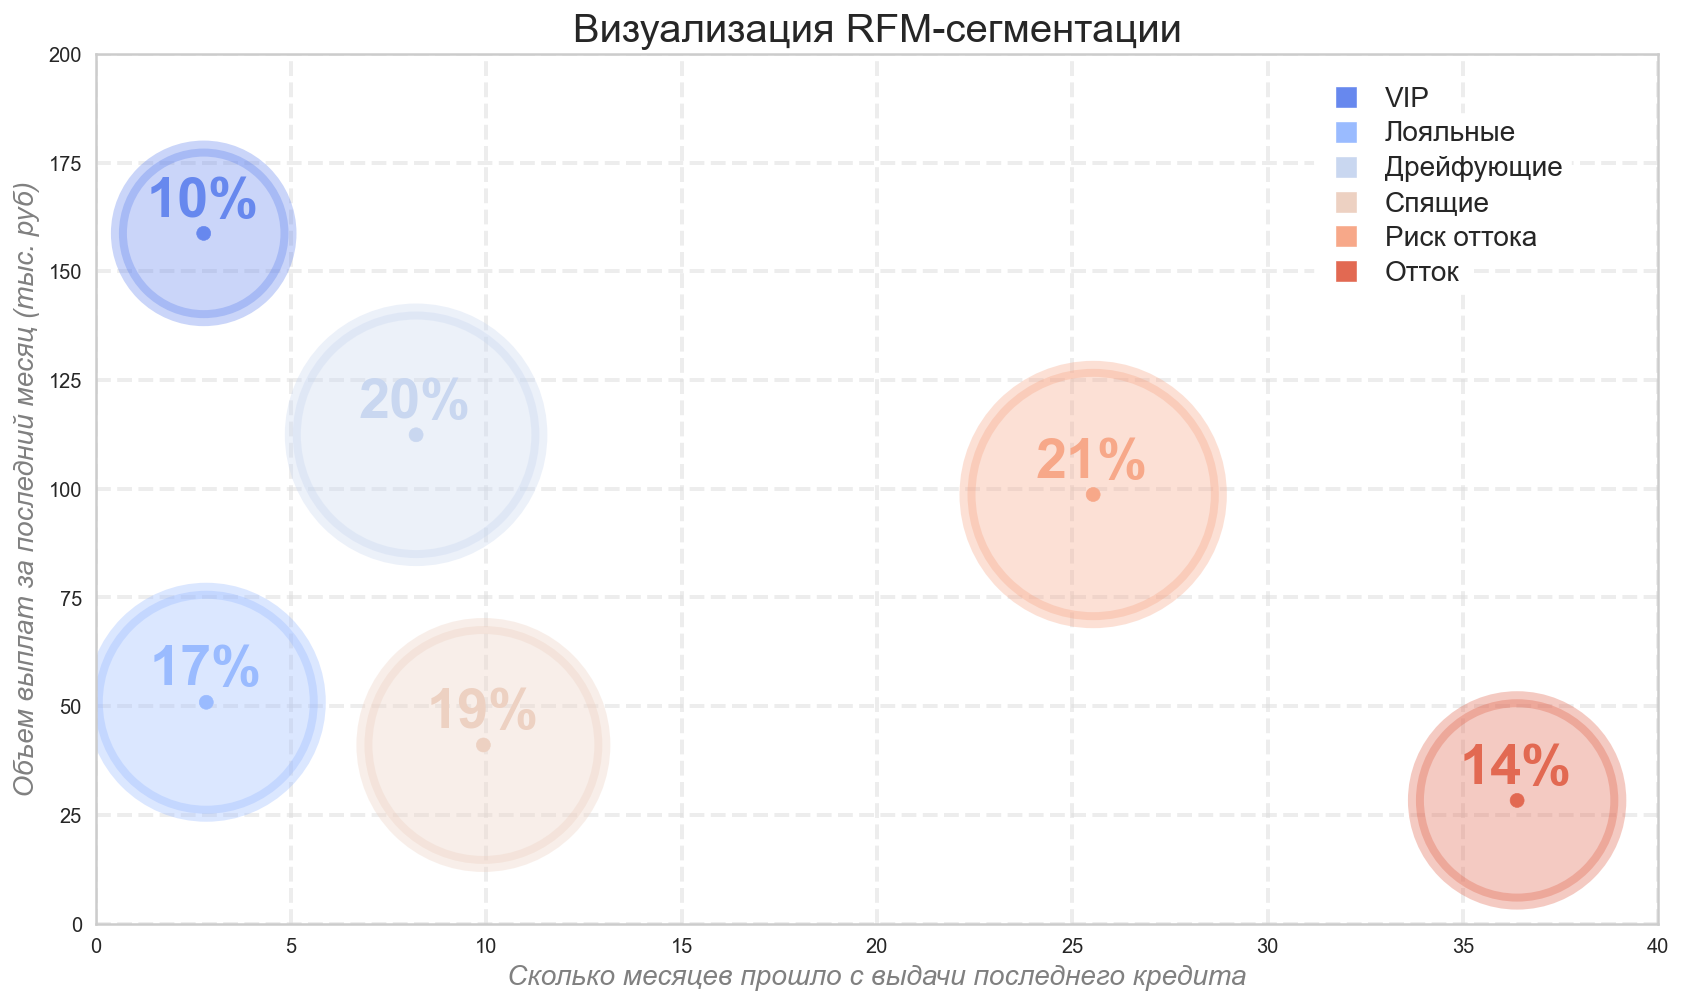

In [77]:
def visualize_rm():    
    cols = [('Отток', 'mean'), ('Риск оттока', 'mean'), ('Спящие', 'mean'),
            ('Дрейфующие', 'mean'), ('Лояльные', 'mean'), ('VIP', 'mean')][::-1]

    x = [numeric1.loc['min_MnthAfterLoan'][i] for i in cols] # recency
    y = [numeric1.loc['sum_of_paym_months'][i] for i in cols] # monetary
    s = np.array([len(df[df.segment == i[0]]) / len(df) for i in cols])
    colors = sns.color_palette(palette='coolwarm', n_colors=len(cols))
    labels = np.array([i[0] for i in cols])
    len_lab = len(labels)
    prc = [str(round(i * 100))+'%' for i in s]
    xleg = [32] * len(cols)
    yleg = np.arange(150, 191, 8)

    fig, ax = plt.subplots(figsize=(14, 8))

    ax.scatter(x, y, s*75000, c=colors, edgecolors=colors, alpha=.35, linewidths=8)
    ax.scatter(x, y, c=colors)
    ax.scatter(x=xleg, y=yleg, c='white', marker='s', s=1000)
    ax.scatter(x=xleg, y=yleg, c=colors[::-1], marker='s', s=100)
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 200)
    ax.set_title('Визуализация RFM-сегментации', fontsize=20)
    ax.set_xlabel('Сколько месяцев прошло с выдачи последнего кредита',
                  fontsize=14, fontstyle='italic', c='grey')
    ax.set_ylabel('Объем выплат за последний месяц (тыс. руб)',
                  fontsize=14, fontstyle='italic', c='grey')
    ax.grid(color='gainsboro', ls='--', lw=2, alpha=.5)
    for i in range(len(x)):
        plt.annotate(prc[i],
                     xy=(x[i], y[i]),
                     xytext=(x[i]-len(prc[i])/2.05, y[i]+4),
                     fontsize=28,
                     c=colors[i],
                     fontweight='bold')
    for j in range(1, len(xleg)+1):
        plt.annotate(cols[j-1][0],
                     xy=(xleg[-j], yleg[-j]),
                     xytext=(xleg[-j]+1, yleg[-j]-2),
                     fontsize=14,
                     backgroundcolor='white')
visualize_rm()